#### Exercise 1 - Kaggle Small Dataset - Congressional Voting

This dataset contains information on different congress members. The goal here is to analyze the data and predict the part of the congress member. 

##### Important Libraries

In [133]:
import pandas as pd
import numpy as np
from scipy.io import arff
import seaborn as sns
import matplotlib.pyplot as plt
import openml


#sklearn
from sklearn.model_selection import train_test_split 
from sklearn import tree
from sklearn.metrics import recall_score,accuracy_score,confusion_matrix, ConfusionMatrixDisplay, precision_score, make_scorer,balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,KFold
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler


#### Loading the data

In [3]:
# loading the data
congress = pd.read_csv('data/congress/CongressionalVotingID.shuf.lrn.csv')


In [4]:
congress

,ID,class,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,249,republican,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
1,140,democrat,y,n,y,n,n,y,y,y,y,n,n,n,n,n,y,y
2,383,democrat,y,y,n,y,y,y,n,n,n,n,y,n,y,y,n,unknown
3,201,democrat,n,n,y,n,n,n,y,y,y,n,n,n,n,y,y,y
4,297,republican,n,n,y,y,y,y,n,n,n,y,n,y,y,y,y,y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,106,democrat,y,y,y,n,n,n,n,y,y,n,y,n,n,n,y,y
214,271,democrat,y,y,y,n,n,n,y,y,y,n,n,n,n,n,y,y
215,275,republican,y,n,n,y,y,n,y,n,n,y,n,n,n,y,y,y
216,354,republican,n,n,y,y,y,y,y,n,n,y,y,y,y,y,n,y


#### Data exploration and preprocessing

In [5]:
# Number of samples and number of attributes
num_samples = congress.shape[0]
num_attributes = congress.shape[1] - 1 # last one is the class annotation
print("The number of samples is: ", str(num_samples))
print("The number of attributes is: ", str(num_attributes))

The number of samples is:  218
The number of attributes is:  17


In [340]:
# print number of unknown values:
num_unknown = 0
for n in congress.columns:
  num_unknown_per_feature = congress.loc[:,n].isin(['unknown']).sum(axis=0)
  num_unknown += num_unknown_per_feature
  print(n, ':', num_unknown_per_feature)
print('total unknown:', num_unknown)

#for the moment, I decided to keep these missing values as they are

ID : 0
class : 0
handicapped-infants : 7
water-project-cost-sharing : 21
adoption-of-the-budget-resolution : 4
physician-fee-freeze : 6
el-salvador-aid : 9
religious-groups-in-schools : 5
anti-satellite-test-ban : 6
aid-to-nicaraguan-contras : 10
mx-missile : 12
immigration : 4
synfuels-crporation-cutback : 13
education-spending : 16
superfund-right-to-sue : 14
crime : 7
duty-free-exports : 14
export-administration-act-south-africa : 58
total unknown: 206


In [6]:
#missing values
congress.isna().sum()

ID                                        0
class                                     0
handicapped-infants                       0
water-project-cost-sharing                0
adoption-of-the-budget-resolution         0
physician-fee-freeze                      0
el-salvador-aid                           0
religious-groups-in-schools               0
anti-satellite-test-ban                   0
aid-to-nicaraguan-contras                 0
mx-missile                                0
immigration                               0
synfuels-crporation-cutback               0
education-spending                        0
superfund-right-to-sue                    0
crime                                     0
duty-free-exports                         0
export-administration-act-south-africa    0
dtype: int64

In [7]:
#types of features
congress.dtypes

ID                                         int64
class                                     object
handicapped-infants                       object
water-project-cost-sharing                object
adoption-of-the-budget-resolution         object
physician-fee-freeze                      object
el-salvador-aid                           object
religious-groups-in-schools               object
anti-satellite-test-ban                   object
aid-to-nicaraguan-contras                 object
mx-missile                                object
immigration                               object
synfuels-crporation-cutback               object
education-spending                        object
superfund-right-to-sue                    object
crime                                     object
duty-free-exports                         object
export-administration-act-south-africa    object
dtype: object

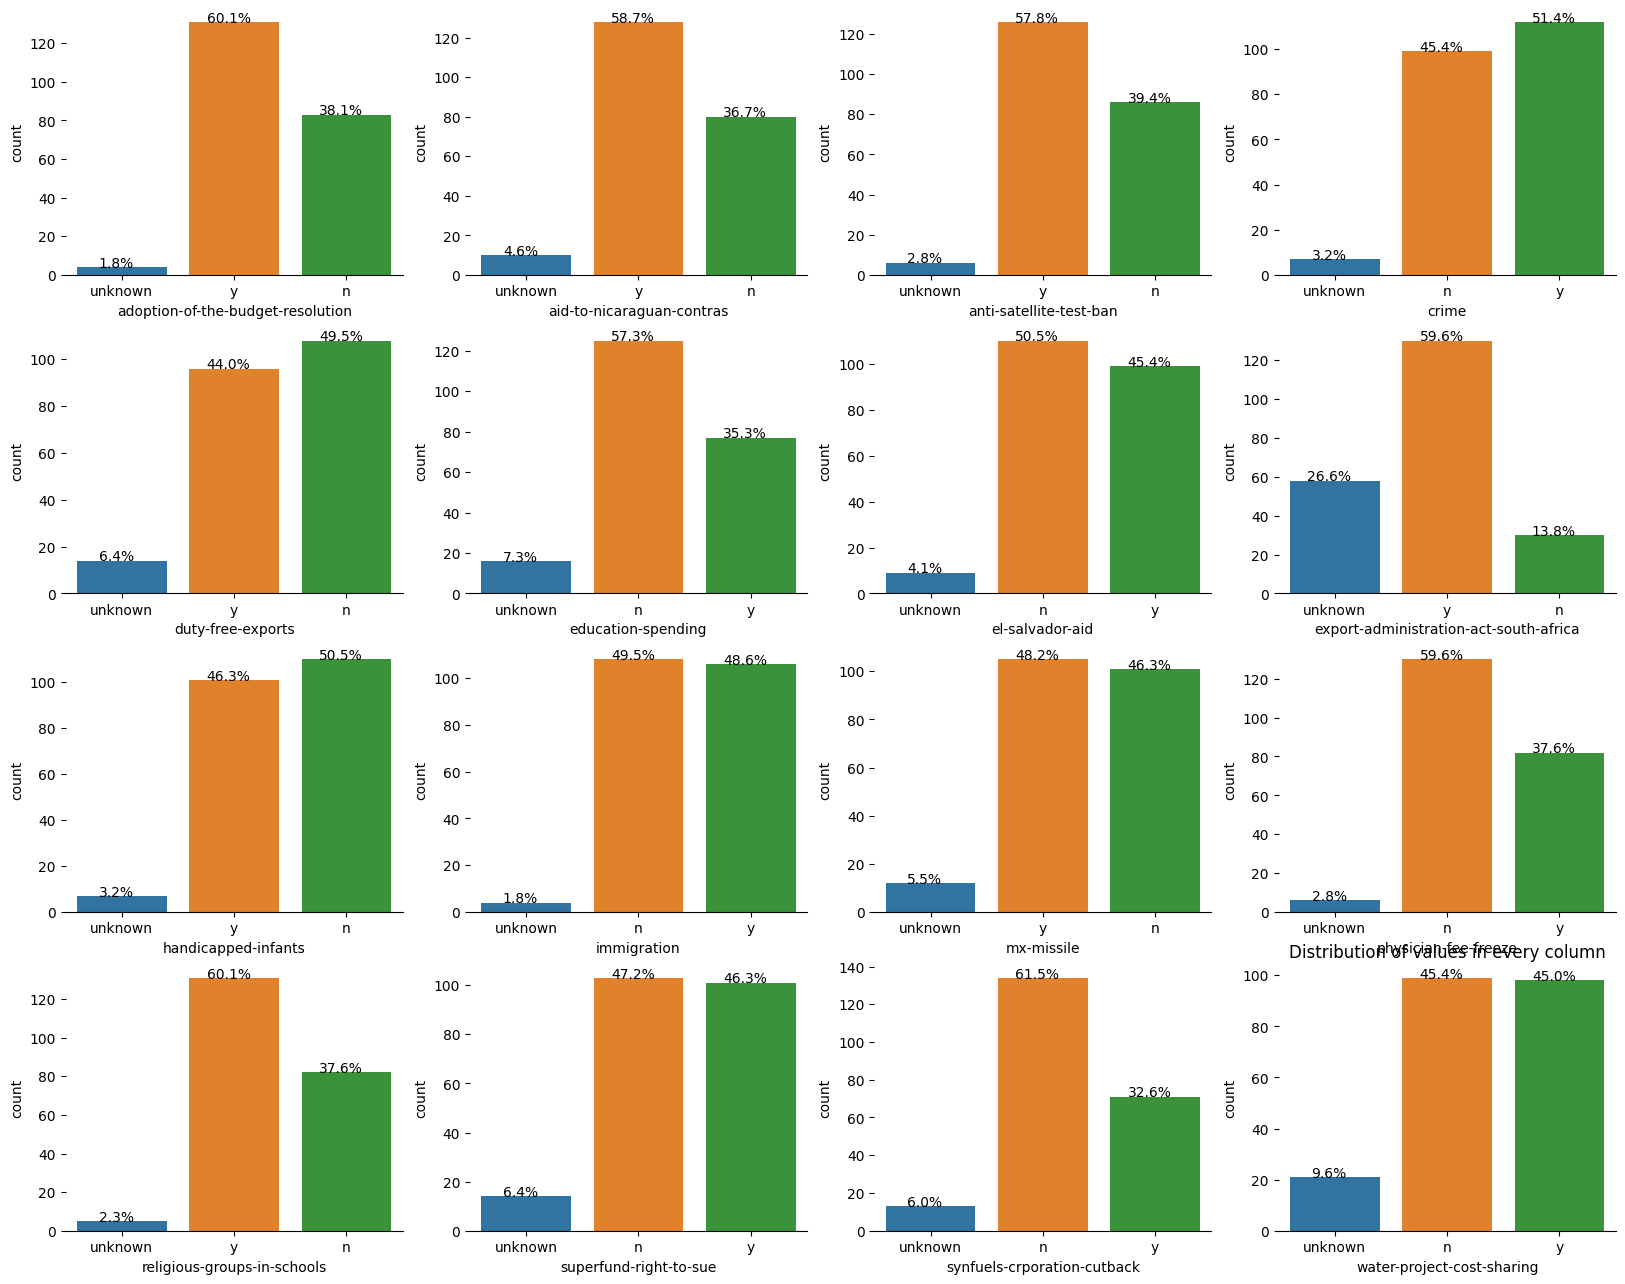

In [8]:
# Plotting the categorical variables
categorical_columns = congress.columns.difference(['ID','class'])
plt.figure(figsize=(20,20))
for i, variable in enumerate(categorical_columns):
                     plt.subplot(5,4,i+1)
                     order = congress[variable].value_counts(ascending=False).index 
                     ax=sns.countplot(x=congress[variable], data=congress )
                     sns.despine(top=True,right=True,left=True)
                     for p in ax.patches:
                           percentage = '{:.1f}%'.format(100 * p.get_height()/len(congress[variable]))
                           x = p.get_x() + p.get_width() / 2 - 0.05
                           y = p.get_y() + p.get_height()
                           plt.annotate(percentage, (x, y),ha='center')

plt.title('Distribution of values in every column')
plt.show()


Observations:
- `60.1%` of the congressmen voted  for `adoption-of-the-budget-resolution`.
- `58.7%`of the congressmen voted  with `aid-to-nicaraguan-contras`.
- `57.8%`of the congressmen agree with `anti-satellite-test-ban`.
- In the `crime` column `45.4%` have voted against and `51.4%` have voted for. 
- `education-spending` divides the congressmen into `57.3%` no and `35.3%` yes.
- In `duty-free-exports` and `handicapped-infants` the difference between category yes and no is almost 5 in favor of no.
- In `immigration, mix-missile, superfun-right-to-sue and water-project-cost-sharing` the majority have voted against.
- In `superfund-right-to-sue` and `physician-fee-freeze` the majority of votes falls into no category.
- `60.1%` of congressmen voted for `religious-groups-schools`.

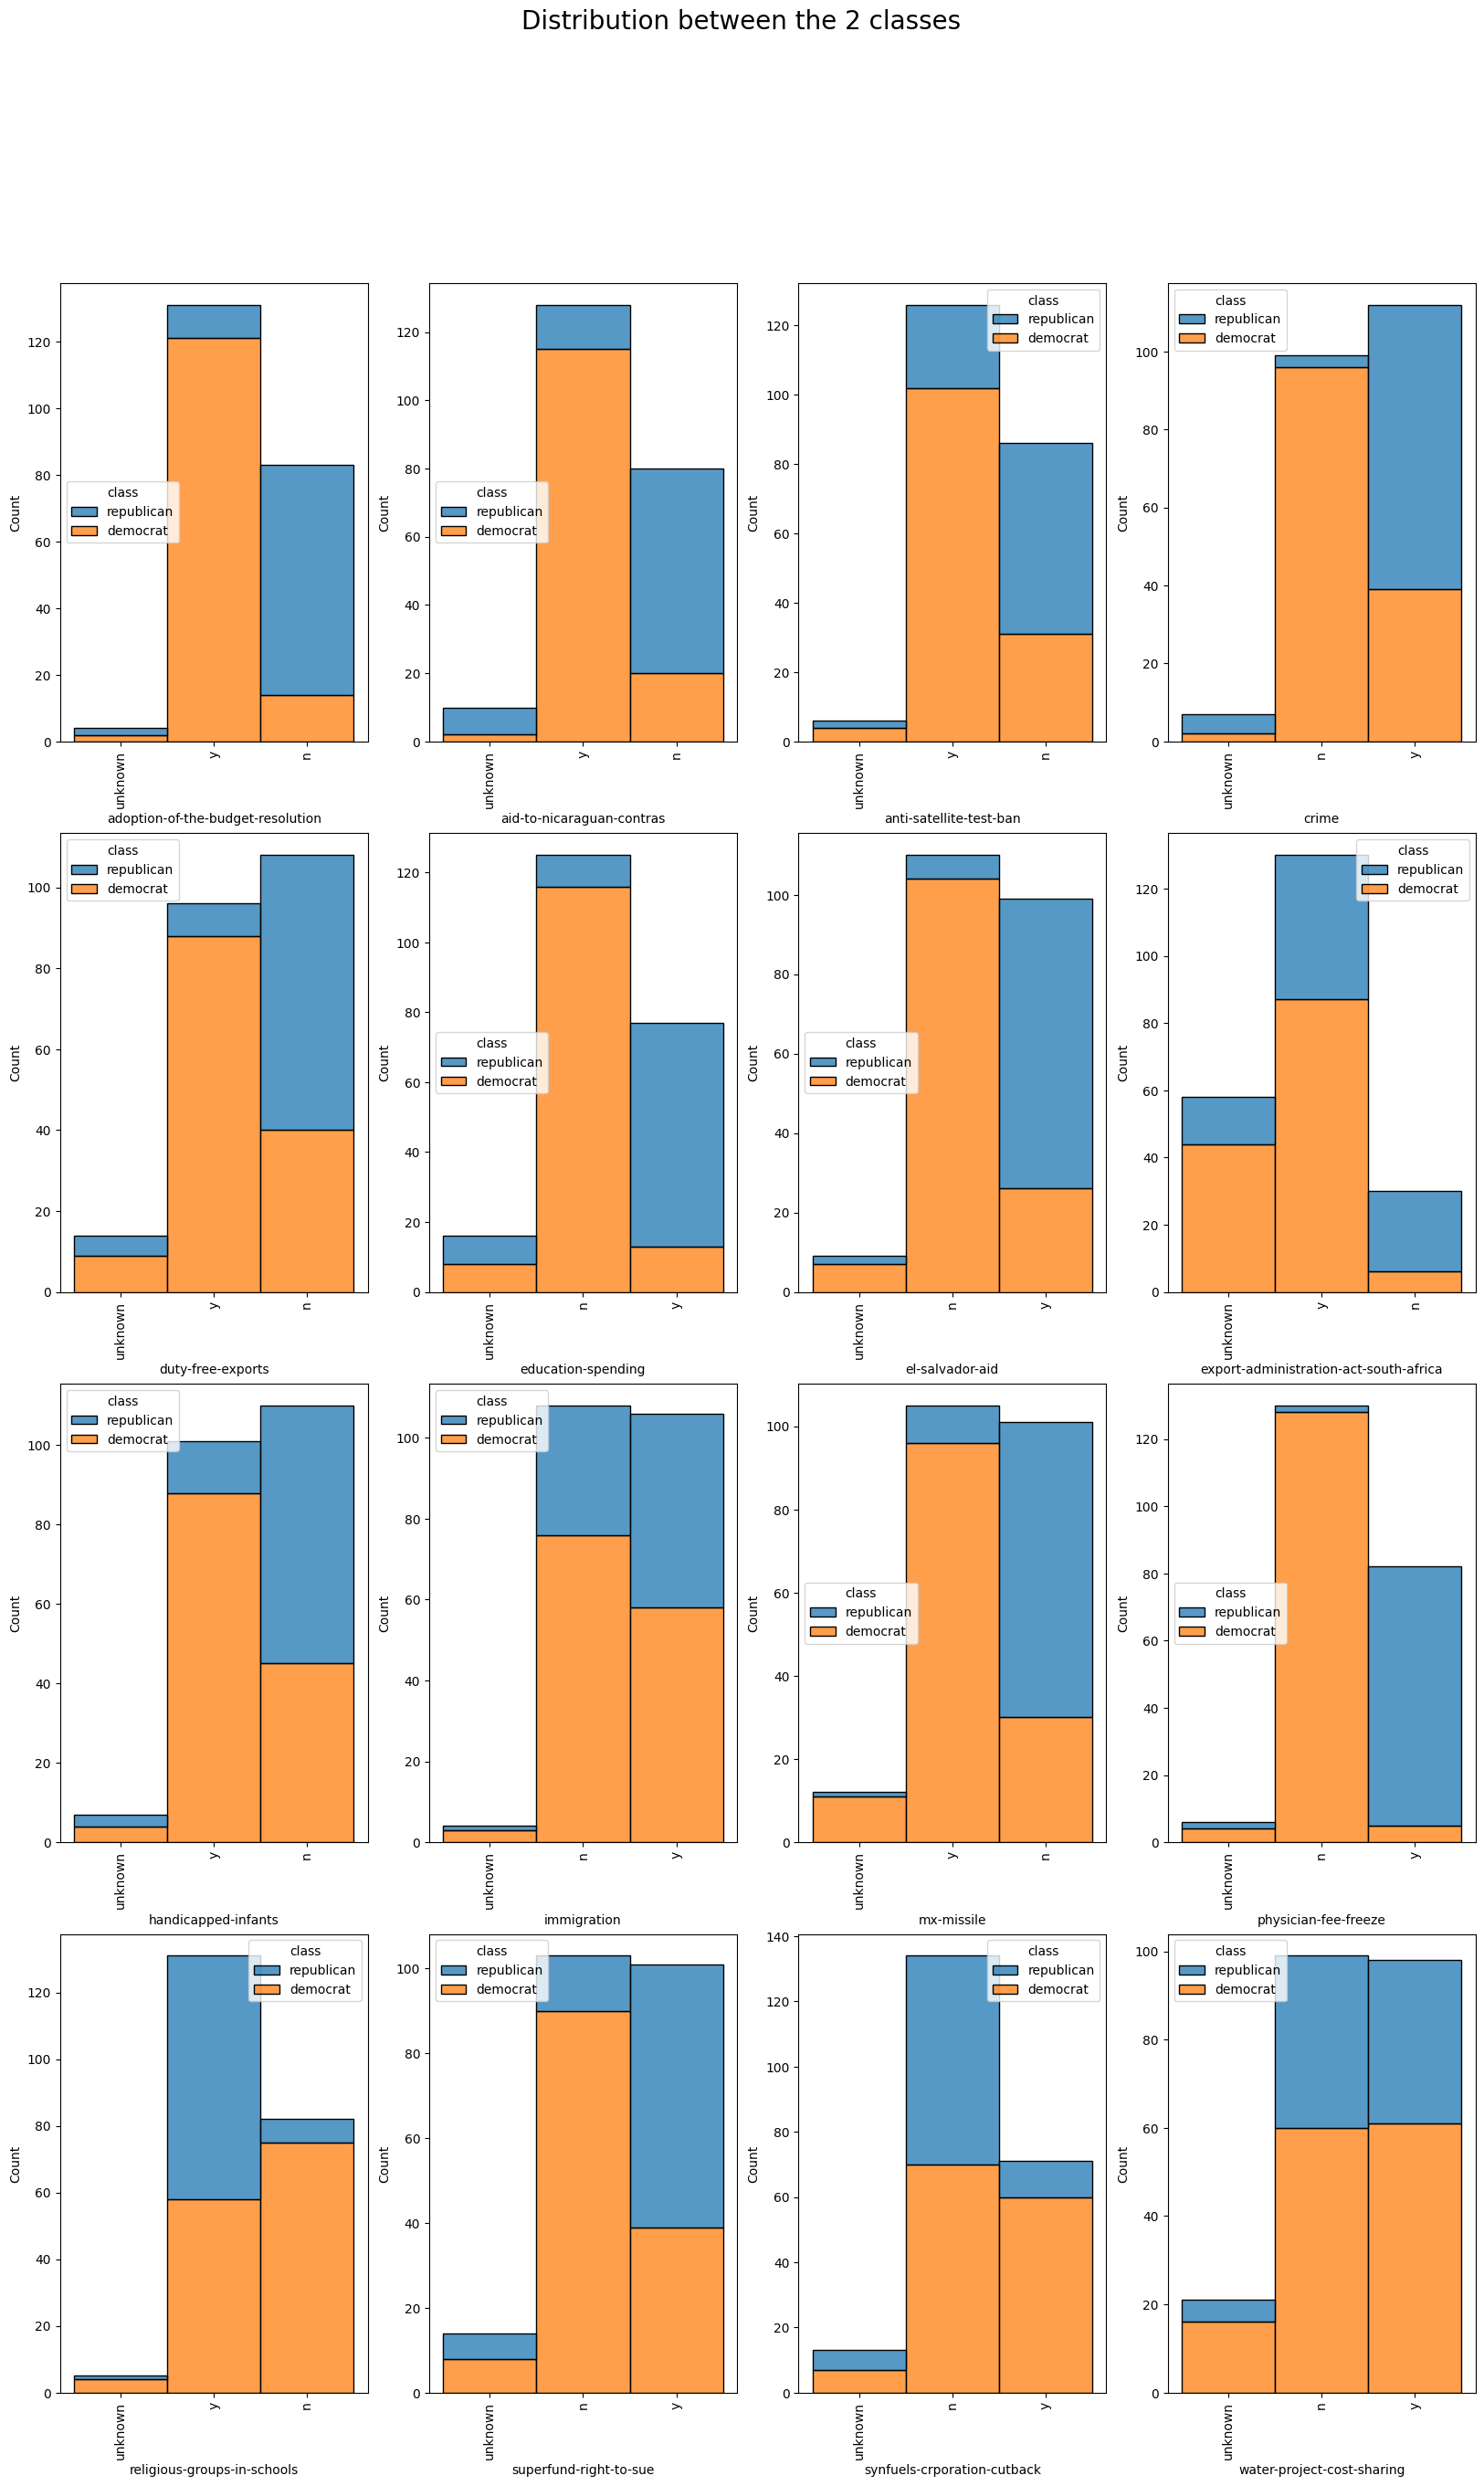

In [9]:
plt.figure(figsize=(20,30))
for i,column in enumerate(categorical_columns):
    plt.subplot(4, 4, i+1)
    sns.histplot(x=congress[column],hue =congress['class'],multiple = 'stack')
    plt.xlabel(column)
    plt.xticks(rotation=90)
plt.suptitle("Distribution between the 2 classes ", fontsize=20)
plt.show()

Observations:

- The majority of congressmen that have voted for `adoption-of-the-budget-resolution` are democrat
- The majority of congressmen that have voted for `aid-to-nicaragua-contras` are democrat
- The majority of congressmen that have voted for `anti-satellite-test-ban` are democrat
- The majority of congressmen that have voted for `crime` bill are republican
- The majority of congressmen that have voted for `duty-free-exports`are democrat
- The majority of congressmen that have voted for `education-spending` are republican
- The majority of congressmen that have voted for `el-salvador-aid` are republican
- etc..







### Train & Test split

- imputation technique after splitting: nearest neighbour(s)

In [10]:
congress

,ID,class,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,249,republican,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
1,140,democrat,y,n,y,n,n,y,y,y,y,n,n,n,n,n,y,y
2,383,democrat,y,y,n,y,y,y,n,n,n,n,y,n,y,y,n,unknown
3,201,democrat,n,n,y,n,n,n,y,y,y,n,n,n,n,y,y,y
4,297,republican,n,n,y,y,y,y,n,n,n,y,n,y,y,y,y,y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,106,democrat,y,y,y,n,n,n,n,y,y,n,y,n,n,n,y,y
214,271,democrat,y,y,y,n,n,n,y,y,y,n,n,n,n,n,y,y
215,275,republican,y,n,n,y,y,n,y,n,n,y,n,n,n,y,y,y
216,354,republican,n,n,y,y,y,y,y,n,n,y,y,y,y,y,n,y


In [11]:
X = congress.drop(['class'], axis=1)
Y = congress[['class', 'ID']] # have to take ID into account because of the output format

#Splitting data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state = 1234,stratify=Y['class'])



#### Data imputation: Train


In [12]:
# dropping this column since it does not bring any value
X_train.drop('ID', axis=1, inplace=True)

y_train['class'] = y_train['class'].map({'democrat': 1, 'republican': 0})
y_train['class'] = y_train['class'].astype('int64')

y_train_id = y_train['ID']
y_train = y_train['class']

In [13]:
X_train

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
117,n,n,y,n,n,y,y,y,y,y,y,n,n,n,unknown,y
212,n,n,y,n,n,n,y,y,y,y,y,unknown,n,n,y,y
114,y,unknown,y,n,n,n,y,y,y,n,n,n,n,n,y,unknown
42,unknown,n,y,y,n,y,y,y,y,y,n,y,n,y,n,y
113,n,unknown,y,n,n,y,y,y,y,y,n,n,n,y,y,y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,y,n,y,n,n,n,y,y,y,n,n,n,n,n,n,y
145,y,n,y,n,n,n,y,y,y,n,n,n,n,n,y,unknown
196,y,y,y,n,n,n,y,y,y,n,y,n,n,n,y,y
106,n,y,y,n,n,y,n,y,y,y,n,n,y,y,n,y


In [14]:
# kNN imputer
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean')
X_train.replace('unknown', float('nan'), inplace=True)
X_train = X_train.replace({'y':1, 'n':0})

X_train_imputed = imputer.fit_transform(X_train)
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns)


In [15]:
X_train_imputed

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
2,1.0,0.6,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
170,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
171,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
172,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0


#### Data imputation: Test

In [16]:
# dropping this column since it does not bring any value
X_test.drop('ID', axis=1, inplace=True)

y_test['class'] = y_test['class'].map({'democrat': 1, 'republican': 0})
y_test['class'] = y_test['class'].astype('int64')

y_test_id = y_test['ID']
y_test = y_test['class']

In [17]:
# kNN imputer
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean')
X_test.replace('unknown', float('nan'), inplace=True)
X_test = X_test.replace({'y':1, 'n':0})

X_test_imputed = imputer.fit_transform(X_test)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns)


In [18]:
X_test_imputed

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,1.0,1.000000,1.0,0.0,0.0,0.0,1.0,1.000000,1.00000,1.0,1.000000,0.00000,0.000000,0.000000,0.000000,1.000000
1,0.0,1.000000,1.0,0.0,0.0,1.0,0.0,1.000000,1.00000,0.0,1.000000,0.00000,0.174479,0.213692,0.710659,1.000000
2,1.0,0.000000,0.0,0.0,0.0,0.0,1.0,1.000000,1.00000,1.0,0.000000,0.00000,0.000000,1.000000,0.000000,1.000000
3,1.0,1.000000,1.0,0.0,0.0,0.0,1.0,1.000000,1.00000,0.0,0.000000,0.00000,0.000000,0.000000,1.000000,1.000000
4,0.0,0.000000,0.0,1.0,1.0,1.0,0.0,0.000000,0.00000,1.0,0.000000,1.00000,0.000000,1.000000,0.000000,1.000000
5,1.0,1.000000,0.0,1.0,1.0,1.0,1.0,0.000000,0.00000,0.0,0.000000,1.00000,1.000000,1.000000,0.000000,0.000000
6,1.0,0.000000,1.0,0.0,0.0,1.0,1.0,1.000000,1.00000,0.0,0.000000,0.00000,0.000000,0.000000,1.000000,1.000000
7,0.0,0.000000,0.0,1.0,1.0,1.0,0.0,0.000000,0.00000,0.0,0.000000,1.00000,1.000000,1.000000,0.000000,0.000000
8,0.0,1.000000,0.0,1.0,1.0,1.0,0.0,0.000000,0.00000,1.0,0.000000,1.00000,1.000000,1.000000,0.000000,0.000000
9,0.0,1.000000,1.0,0.0,1.0,1.0,1.0,0.000000,0.00000,0.0,1.000000,1.00000,1.000000,1.000000,0.000000,1.000000


### Decision Trees

In [20]:
#Counting the number of samples for each class
print("Number of samples that belong to republican: ", str(len(congress[congress['class']=='republican'])),len(congress[congress['class']=='republican'])/len(congress), '%')
print("Number of samples that belong to democrat: ", str(len(congress[congress['class']=='democrat'])),len(congress[congress['class']=='democrat'])/len(congress), '%')

Number of samples that belong to republican:  81 0.37155963302752293 %
Number of samples that belong to democrat:  137 0.6284403669724771 %


- Our dataset is  imbalanced. 63% of the data is represented by democrat congressmen and 37% by repunlican democrats. Since this may have a massive effect on our prediction and the decision trees will surely be biased toward the dominant class, we can make use of the `class_weight` parameter of the model.

#### Fitting Tree 1

In [21]:
tree_1 = tree.DecisionTreeClassifier(random_state=1)

In [24]:
def evaluate(model,X_train = X_train_imputed,X_test = X_test_imputed,y_train = y_train,y_test=y_test):
    model.fit(X_train,y_train)
    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)

    # accuracy
    print("#"*20)
    print("Accuracy on train: ", accuracy_score(y_train, y_train_predict))
    print("Accuracy on test: ", accuracy_score(y_test, y_test_predict))
    

    print("#"*20)
    print("Recall on train: ", recall_score(y_true = y_train, y_pred = y_train_predict))
    print("Recall on test: ", recall_score(y_true = y_test, y_pred = y_test_predict))
    print("#"*20)
    print("Precision on train: ", precision_score(y_true = y_train, y_pred = y_train_predict))
    print("Precision on test: ", precision_score(y_true = y_test, y_pred = y_test_predict))


    # plot confusion matrices
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    c_1 = confusion_matrix(y_true=y_train, y_pred=y_train_predict)
    cmd_1 = ConfusionMatrixDisplay(c_1, display_labels=['republican','democrat'])
    cmd_1.plot(ax=ax[0], cmap=plt.cm.Blues)
    ax[0].set_title("Confusion matrix: train data")

    c_2 = confusion_matrix(y_true=y_test, y_pred=y_test_predict)
    cmd_2 = ConfusionMatrixDisplay(c_2, display_labels=['republican','democrat'])
    cmd_2.plot(ax=ax[1], cmap=plt.cm.Blues)
    ax[1].set_title("Confusion matrix: test data")

    plt.show()
      
 

####################
Accuracy on train:  1.0
Accuracy on test:  0.8636363636363636
####################
Recall on train:  1.0
Recall on test:  0.8928571428571429
####################
Precision on train:  1.0
Precision on test:  0.8928571428571429


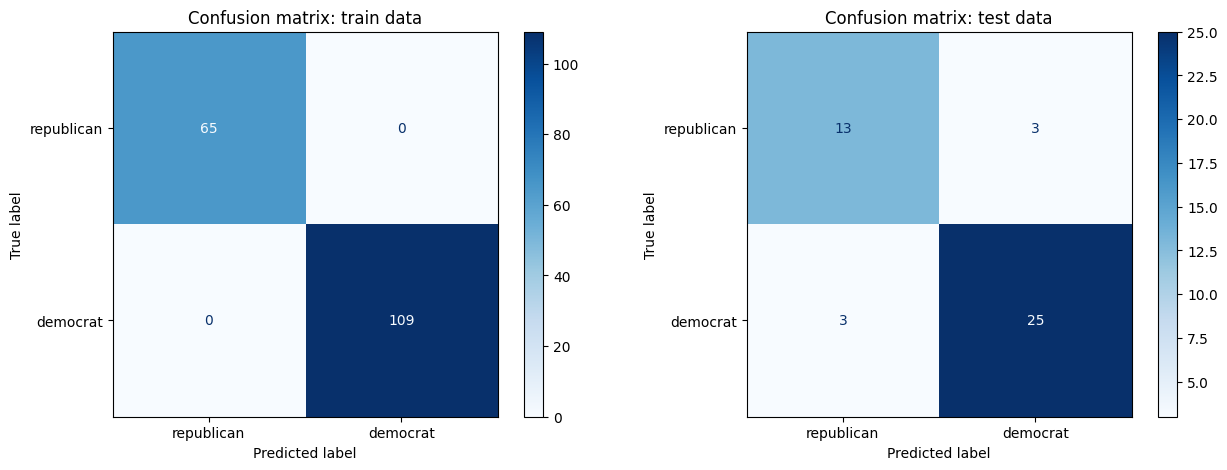

In [25]:
evaluate(tree_1)

Observations:
- As seen above, the accuracy score on the train set is perfect which suggests that our model is highly overfitted

In [26]:
#features of the model
features = list(X_train)

In [27]:
def plottree(model):
    plt.figure(figsize=(20,30))
    plot = tree.plot_tree(model,feature_names=features,filled=True,fontsize=9,node_ids=True,class_names=True)
    for o in plot:
        arrow = o.arrow_patch
        if arrow is not None:
            arrow.set_edgecolor('black')
            arrow.set_linewidth(1)
    plt.show()

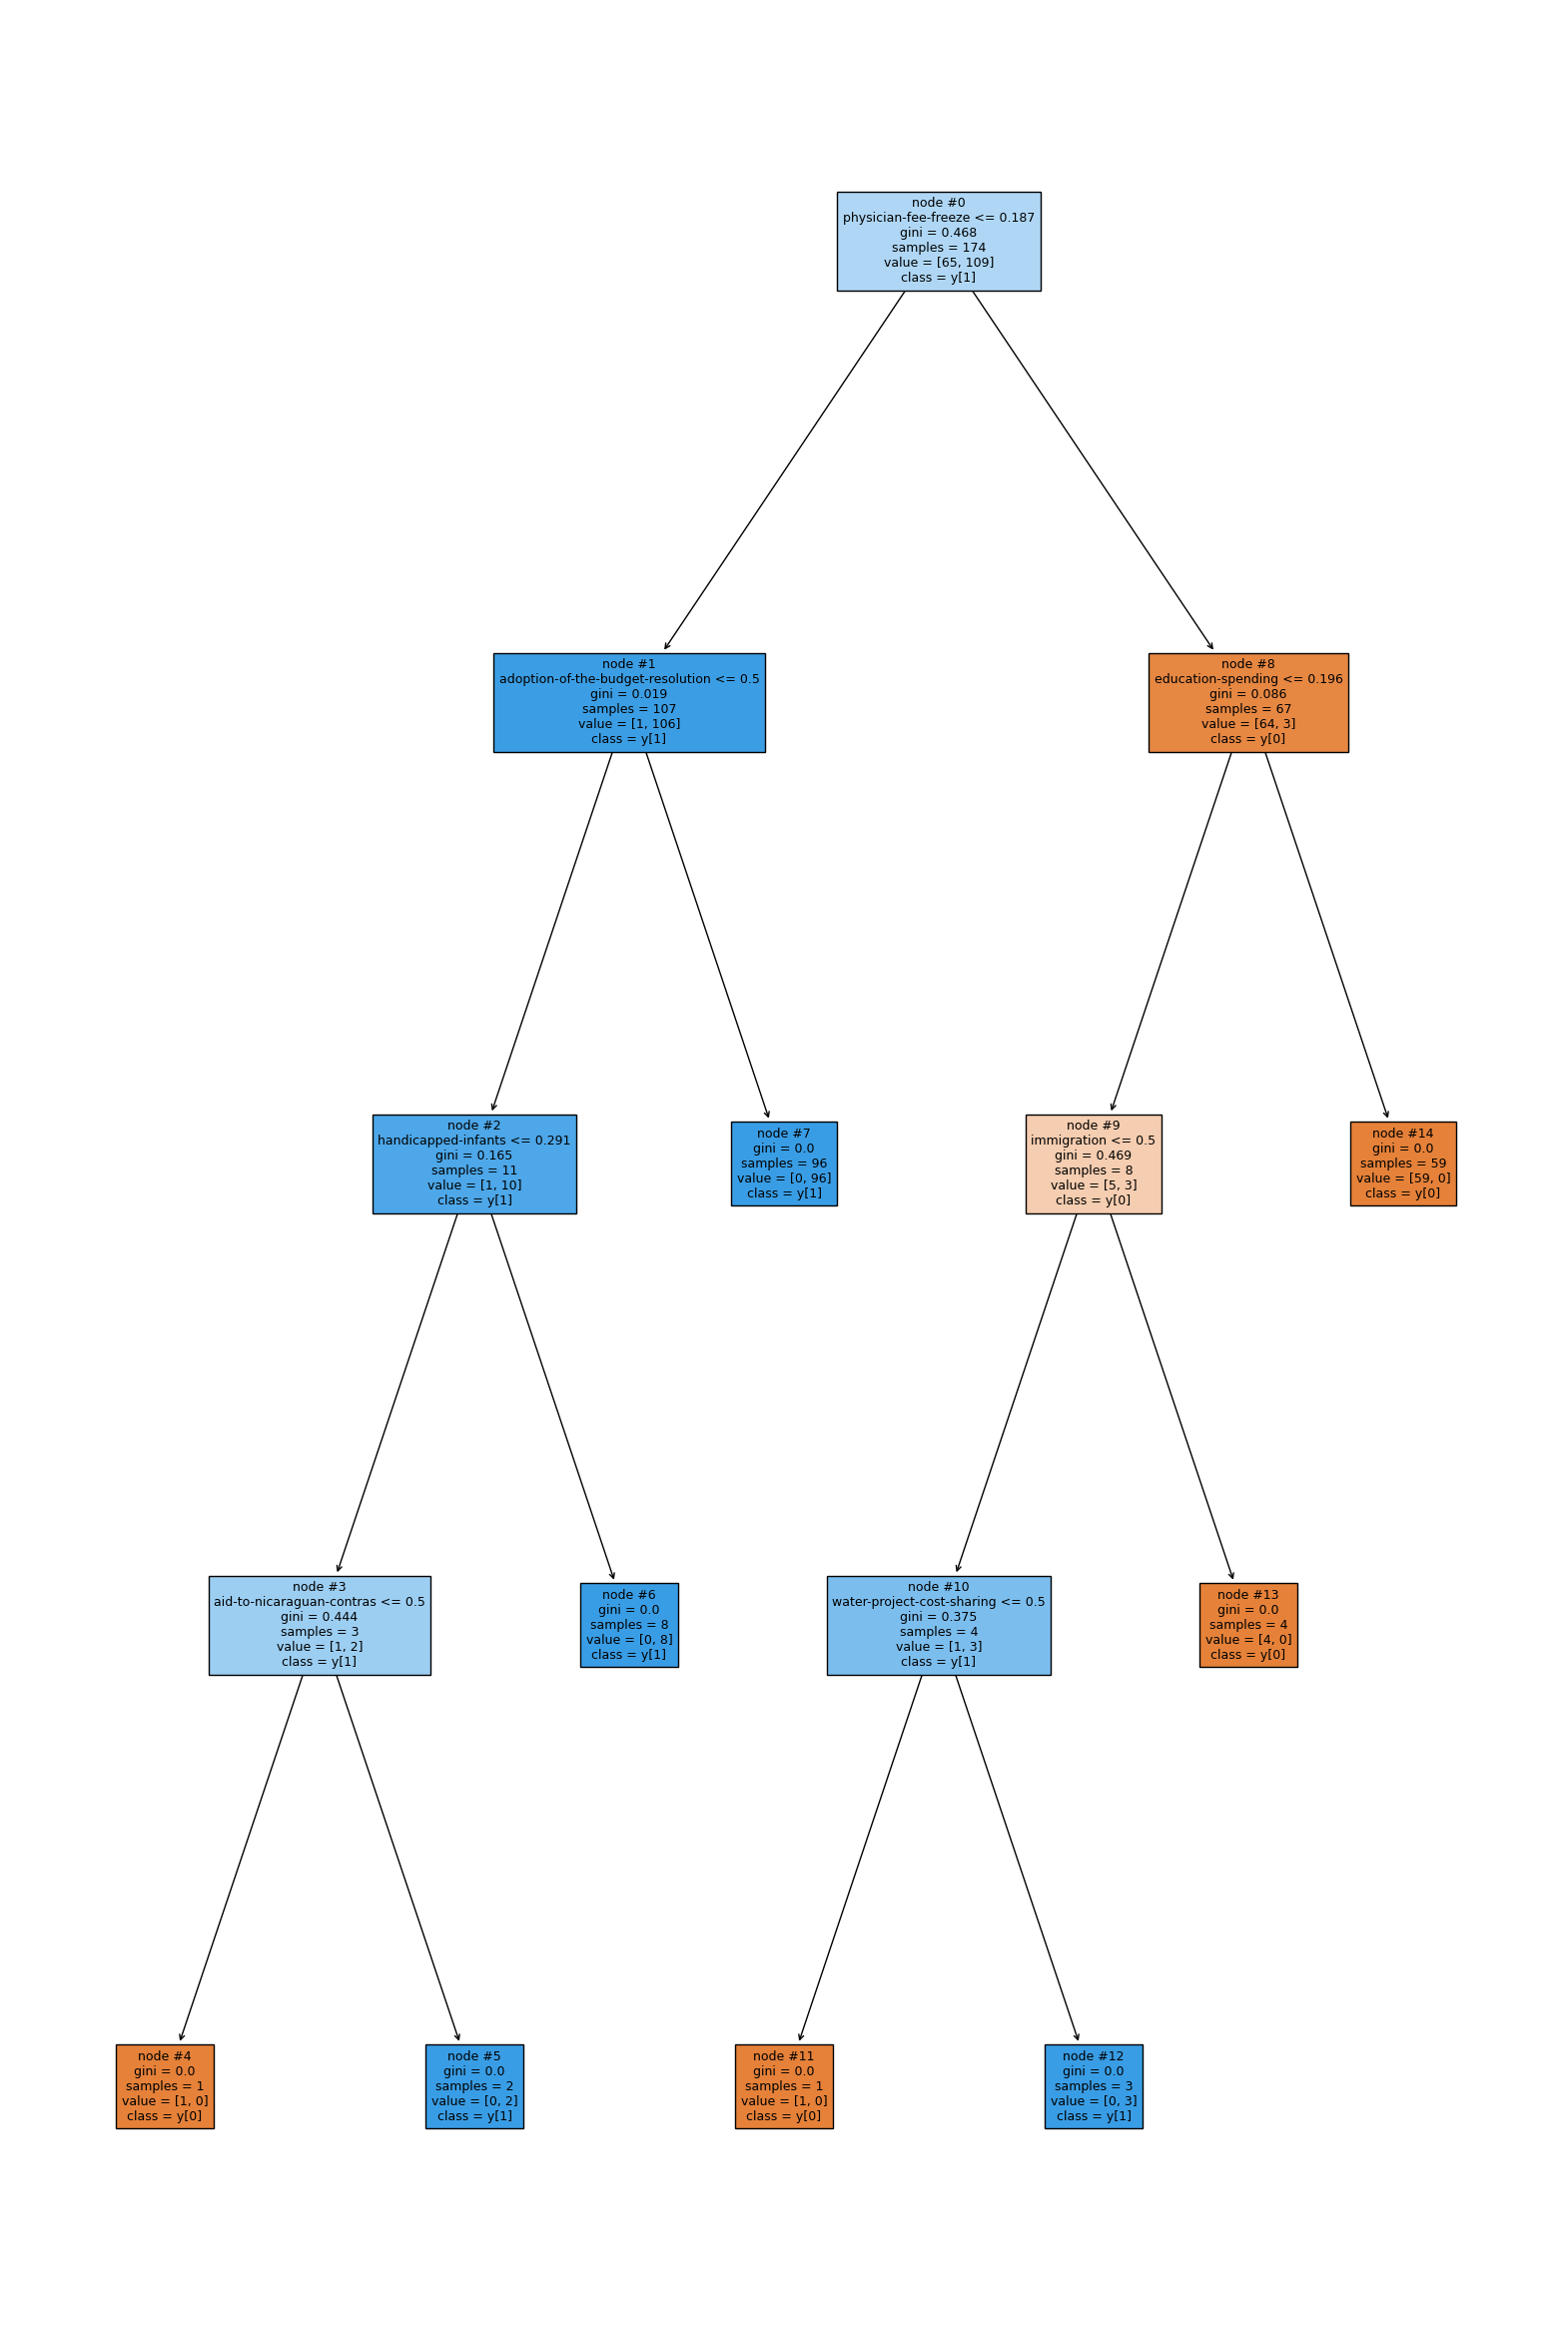

In [28]:
plottree(tree_1)

In [33]:
feat_dict_1= {}
for col, val in sorted(zip(features, tree_1.feature_importances_),key=lambda x:x[1],reverse=True):
        feat_dict_1[col]=val
feat_df_1 = pd.DataFrame({'Feature':feat_dict_1.keys(),'Importance':feat_dict_1.values()})

In [30]:
# function for plotting the features
def plot_features(model):
    feat_dict= {}
    for col, val in sorted(zip(features, model.feature_importances_),key=lambda x:x[1],reverse=True):
        feat_dict[col]=val
    feat_df = pd.DataFrame({'Feature':feat_dict.keys(),'Importance':feat_dict.values()})
    values = feat_df.Importance    
    idx = feat_df.Feature
    plt.figure(figsize=(10,8))
    clrs = ['navy']
    sns.barplot(y=idx,x=values,palette=clrs).set(title='Important features to predict client subscription')
    plt.show()

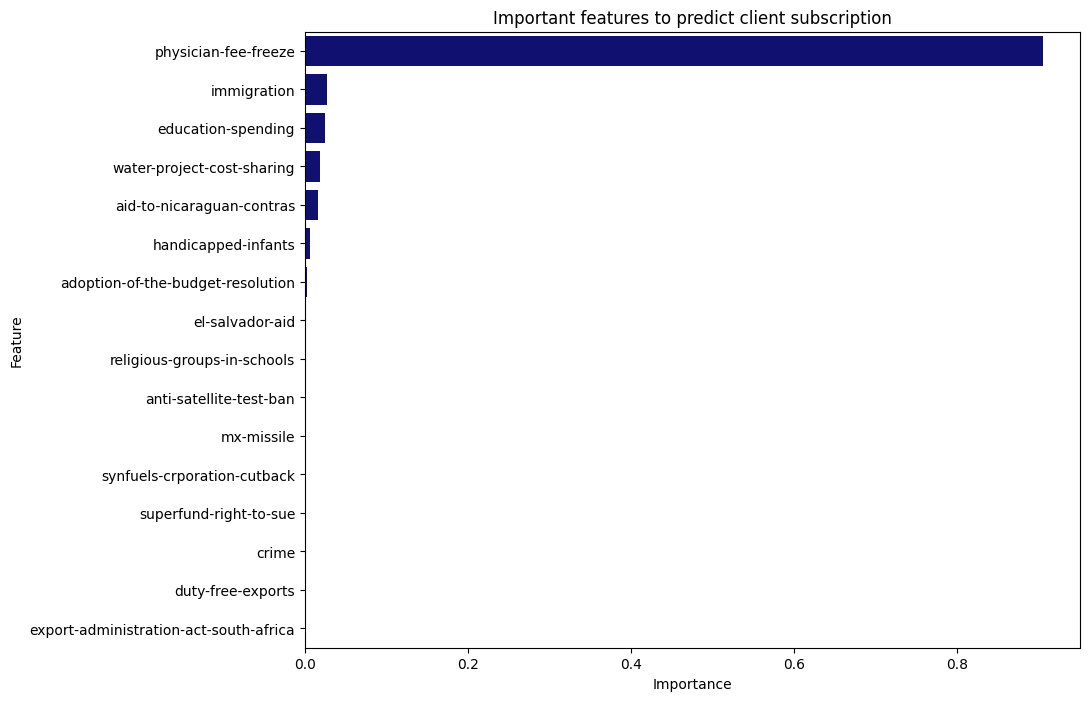

In [31]:
plot_features(tree_1)

Observations:
- The most important features include `physician-fee-freeze_n`, `immigration`,`education-spending, `water-project-cost-sharing`, `aid-to-nicaraguan-congress` and `handicapped-infants`.

#### Fitting a model with the most important features

In [35]:
X_train_new = X_train_imputed[feat_df_1[:6].Feature.to_list()]
X_test_new = X_test_imputed[feat_df_1[:6].Feature.to_list()]

In [36]:
tree_2 = tree.DecisionTreeClassifier(random_state=1)

####################
Accuracy on train:  1.0
Accuracy on test:  0.8863636363636364
####################
Recall on train:  1.0
Recall on test:  0.9285714285714286
####################
Precision on train:  1.0
Precision on test:  0.896551724137931


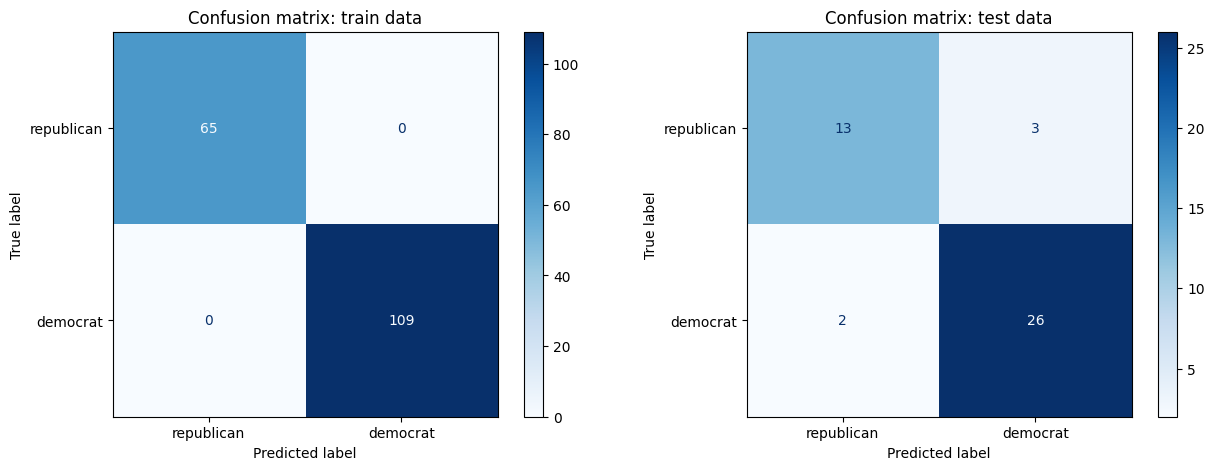

In [37]:
evaluate(tree_2,X_train = X_train_new,X_test = X_test_new)

Observations:
- As seen above, fitting the model on the most important features does not lead into an improvement of the test accuracy

#### Weighted Tree

In [38]:
tree_3 = tree.DecisionTreeClassifier(class_weight = {1:0.40,0:0.60},random_state=1,)

####################
Accuracy on train:  1.0
Accuracy on test:  0.8863636363636364
####################
Recall on train:  1.0
Recall on test:  0.8928571428571429
####################
Precision on train:  1.0
Precision on test:  0.9259259259259259


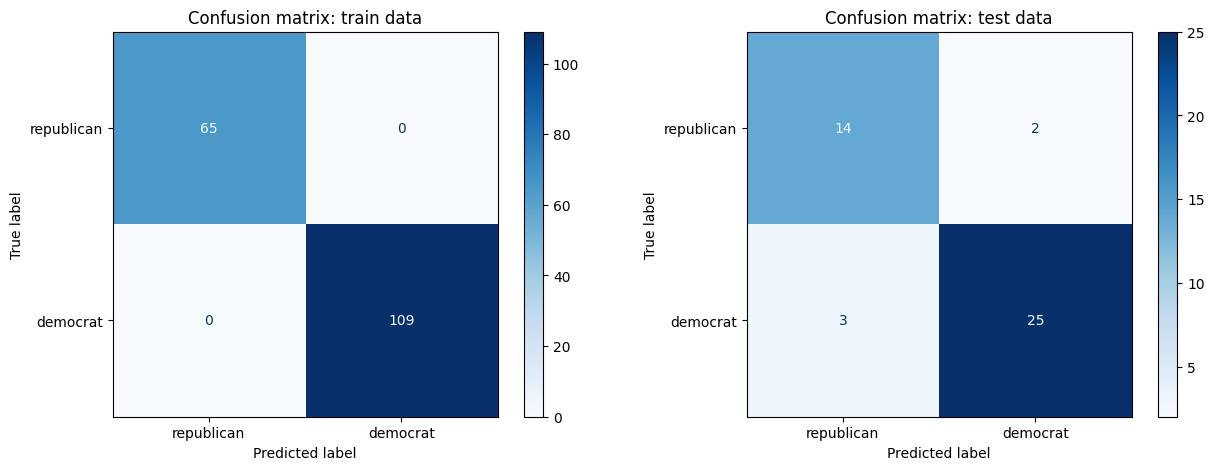

In [39]:
evaluate(tree_3)

Observations:
- The model overfit has not decreased. The perfomance on test does not differ from the Tree 2 where feature selection was applied.

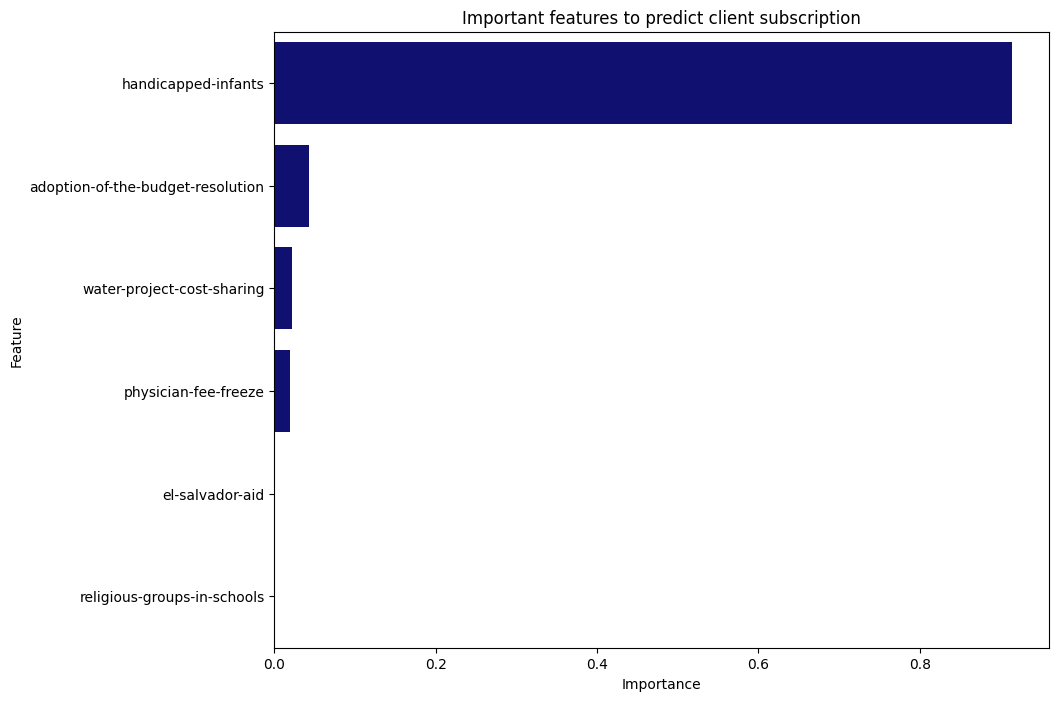

In [41]:
plot_features(tree_3)

In [47]:
feat_dict_2= {}
for col, val in sorted(zip(features, tree_3.feature_importances_),key=lambda x:x[1],reverse=True):
        feat_dict_2[col]=val
feat_df_2 = pd.DataFrame({'Feature':feat_dict_2.keys(),'Importance':feat_dict_2.values()})
# feat_df_2

In [45]:
X_train_new = X_train_imputed[feat_df_2[:4].Feature.to_list()]
X_test_new = X_test_imputed[feat_df_2[:4].Feature.to_list()]

##### Weighted Tree on most important features

####################
Accuracy on train:  0.9827586206896551
Accuracy on test:  0.9090909090909091
####################
Recall on train:  0.9724770642201835
Recall on test:  0.8928571428571429
####################
Precision on train:  1.0
Precision on test:  0.9615384615384616


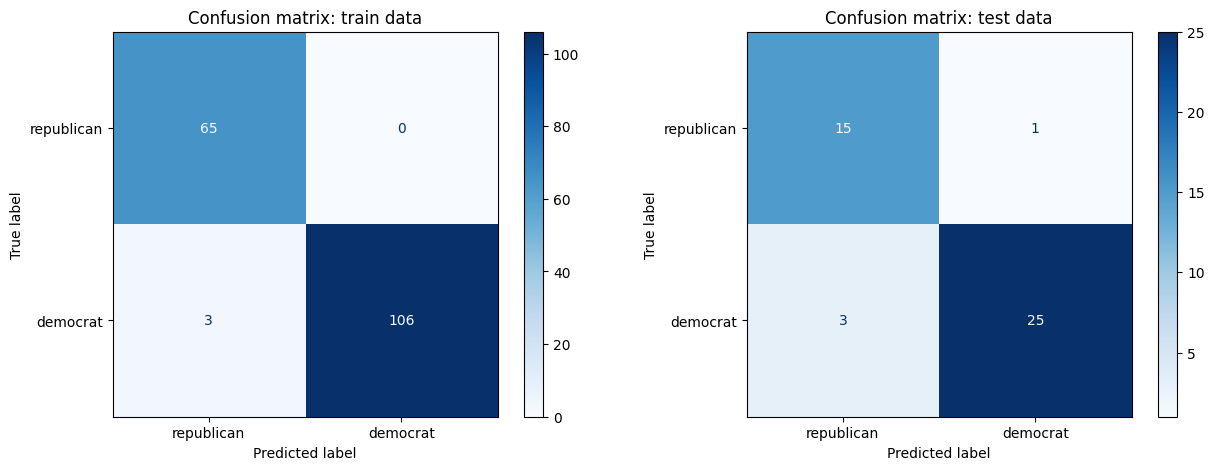

In [46]:
evaluate(tree_3,X_train = X_train_new,X_test = X_test_new)

Observations:
- Applying Feature Selection on our weighted tree leads to a decrease of model overfit and to an increase of test accuracy

#### Oversampling the minority class

In [49]:

ratio = 1  # ratio of majority class to minority class
oversampler = RandomOverSampler( random_state=1)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_imputed, y_train)

In [50]:
n_minority = len(y_train_resampled[y_train_resampled == 0])
n_majority = len(y_train_resampled[y_train_resampled == 1])
print(n_minority, n_majority)

109 109


####################
Accuracy on train:  1.0
Accuracy on test:  0.8863636363636364
####################
Recall on train:  1.0
Recall on test:  0.8928571428571429
####################
Precision on train:  1.0
Precision on test:  0.9259259259259259


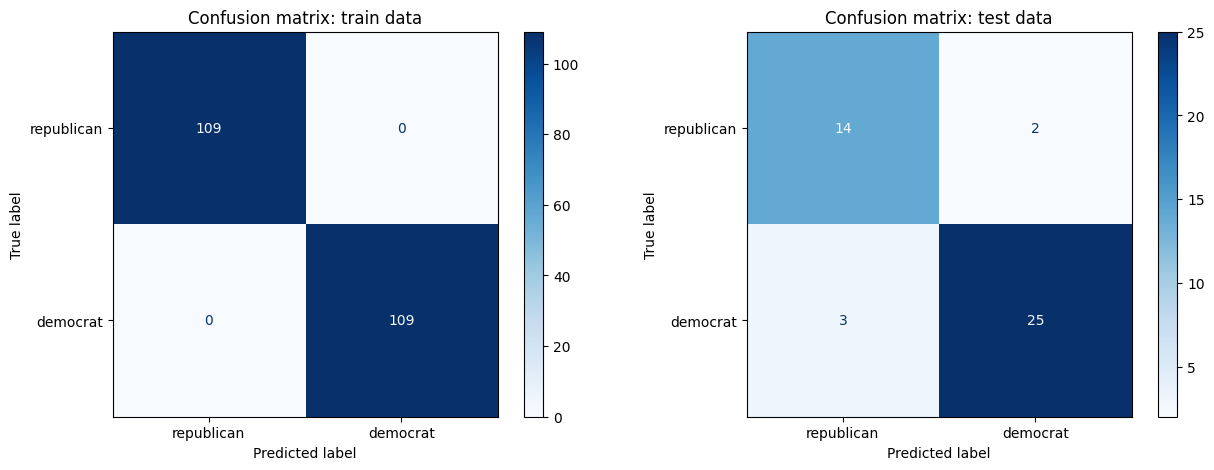

In [51]:
tree_4 = tree.DecisionTreeClassifier(random_state=1)
evaluate(tree_4,X_train = X_train_resampled,y_train = y_train_resampled)

Observations:
- As seen above, our decision tree on oversampled data did not experience any improvement when compared to the first models.

##### Grid search for paramter tuning

In [161]:
imputer =  KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean')

pipeline = Pipeline([
    ('imputer', imputer),
    ('tree',tree.DecisionTreeClassifier(random_state=1))
])

parameters = {'tree__max_depth': np.arange(1,20), 
              'tree__max_leaf_nodes' : [5,10,15,20,25,30,35,40,45,50],
              'tree__class_weight':[{1:0.40,0:0.60}, {1:0.30,0:0.70},{1:0.20,0:0.80}],
              'tree__criterion': ['gini','entropy','log_loss'],   
              'imputer__n_neighbors':[5],
              'imputer__weights':['distance'],
              'imputer__metric': ['nan_euclidean']}
              
scorer = make_scorer(accuracy_score)

kf = KFold(n_splits= 10, shuffle=True, random_state=1)

grid = GridSearchCV(estimator = pipeline,param_grid = parameters,scoring = scorer, cv = kf)

start_time = time.time()
grid = grid.fit(X_train,y_train)
end_time = time.time()
print('Average execution time across 10 folds ',str((end_time-start_time)/10))

Average execution time across 10 fold  104.11816573143005


In [177]:
#best combination
# DecisionTreeClassifier(class_weight={0: 0.6, 1: 0.4}, max_depth=3,
                    #    max_leaf_nodes=5, random_state=1)
tree_best = grid.best_estimator_
tree_best


Pipeline(steps=[('imputer', KNNImputer(weights='distance')),
                ('tree',
                 DecisionTreeClassifier(class_weight={0: 0.6, 1: 0.4},
                                        max_depth=1, max_leaf_nodes=5,
                                        random_state=1))])

####################
Accuracy on train:  0.9770114942528736
Accuracy on test:  0.9090909090909091
####################
Recall on train:  0.9724770642201835
Recall on test:  0.8928571428571429
####################
Precision on train:  0.9906542056074766
Precision on test:  0.9615384615384616


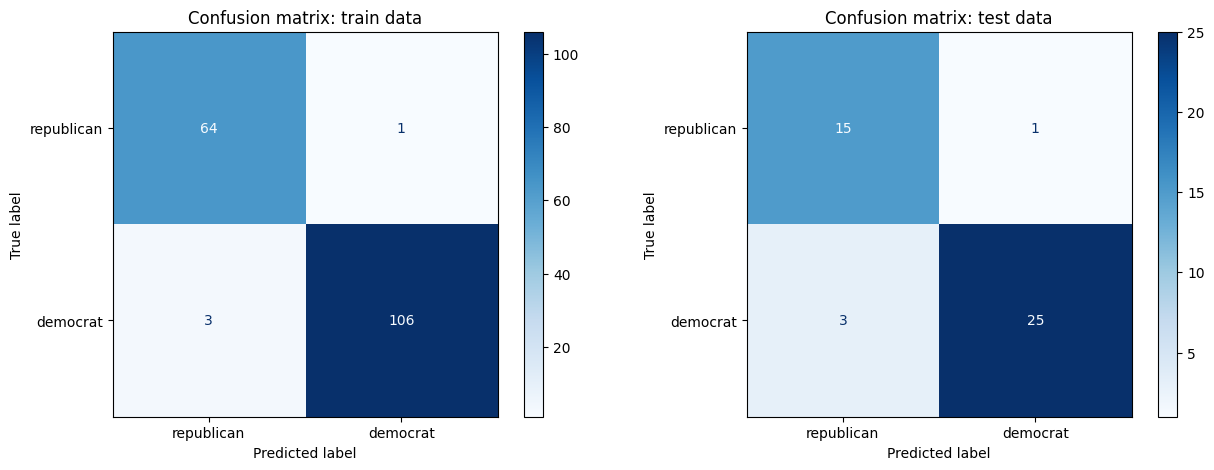

In [178]:
evaluate(tree_best,X_train,X_test)

Observations:
- After fitting the model, the overfit on train has decreased and performance on test has improved slightly.

In [158]:
import time

#parameter grid
imputer =  KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean')

pipeline = Pipeline([
    ('imputer', imputer),
    ('tree',tree.DecisionTreeClassifier(random_state=1))
])

param_dist = {'tree__max_depth': np.arange(1,20), 
              'tree__max_leaf_nodes' : [5,10,15,20,25,30,35,40,45,50],
              'tree__class_weight':[{1:0.40,0:0.60}, {1:0.30,0:0.70},{1:0.20,0:0.80}],
              'tree__criterion': ['gini','entropy','log_loss'],
              'imputer__n_neighbors':[5],
              'imputer__weights':['distance'],
              'imputer__metric': ['nan_euclidean']}


kf = KFold(n_splits= 10, shuffle=True, random_state=1)

scorer = make_scorer(accuracy_score)

rand_search_tree = RandomizedSearchCV(estimator = pipeline, param_distributions = param_dist, 
                          cv = kf, n_jobs = -1, verbose = 2,scoring = scorer)




In [162]:
start_time = time.time()
rand_search_tree.fit(X_train,y_train)
end_time = time.time()
print('Average execution time across 10 fold ',str((end_time-start_time)/10))

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END imputer__metric=nan_euclidean, imputer__n_neighbors=5, imputer__weights=distance, tree__class_weight={1: 0.3, 0: 0.7}, tree__criterion=gini, tree__max_depth=3, tree__max_leaf_nodes=50; total time=   0.1s
[CV] END imputer__metric=nan_euclidean, imputer__n_neighbors=5, imputer__weights=distance, tree__class_weight={1: 0.3, 0: 0.7}, tree__criterion=gini, tree__max_depth=3, tree__max_leaf_nodes=50; total time=   0.1s
[CV] END imputer__metric=nan_euclidean, imputer__n_neighbors=5, imputer__weights=distance, tree__class_weight={1: 0.3, 0: 0.7}, tree__criterion=gini, tree__max_depth=3, tree__max_leaf_nodes=50; total time=   0.1s
[CV] END imputer__metric=nan_euclidean, imputer__n_neighbors=5, imputer__weights=distance, tree__class_weight={1: 0.3, 0: 0.7}, tree__criterion=gini, tree__max_depth=3, tree__max_leaf_nodes=50; total time=   0.1s
[CV] END imputer__metric=nan_euclidean, imputer__n_neighbors=5, imputer__weights=dist

In [165]:
#DecisionTreeClassifier(class_weight={0: 0.7, 1: 0.3}, criterion='entropy',
                    #    max_depth=2, max_leaf_nodes=30, random_state=1)
tree_best_rand = rand_search_tree.best_estimator_
tree_best_rand

Pipeline(steps=[('imputer', KNNImputer(weights='distance')),
                ('tree',
                 DecisionTreeClassifier(class_weight={0: 0.7, 1: 0.3},
                                        criterion='entropy', max_depth=2,
                                        max_leaf_nodes=30, random_state=1))])

####################
Accuracy on train:  0.9770114942528736
Accuracy on test:  0.9090909090909091
####################
Recall on train:  0.9724770642201835
Recall on test:  0.8928571428571429
####################
Precision on train:  0.9906542056074766
Precision on test:  0.9615384615384616


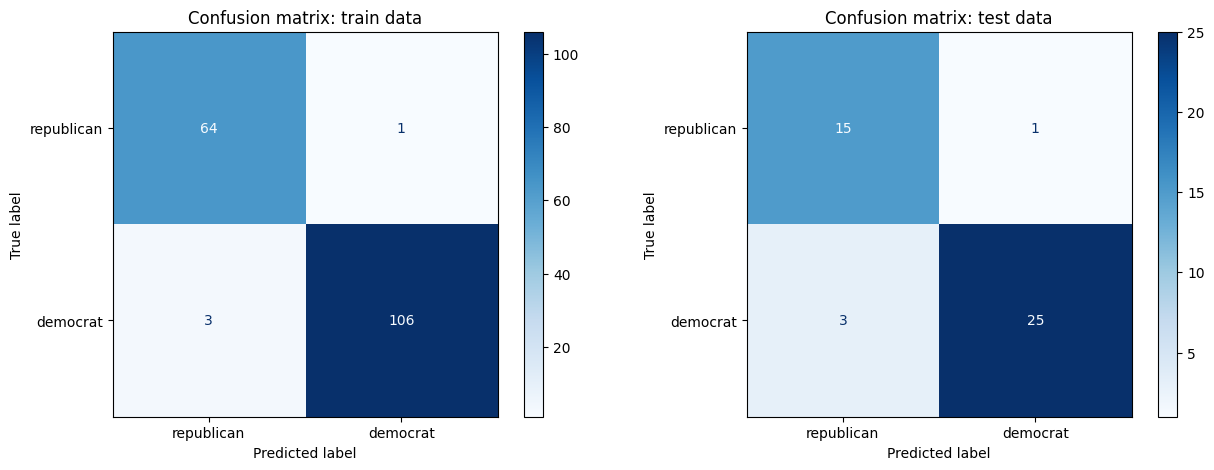

In [179]:
evaluate(tree_best_rand,X_train,X_test)

Observations:
- Randomized and GridSearch best models deliver similar results.

##### Cost complexity pruning

In [167]:
tree_ = tree.DecisionTreeClassifier(random_state = 1)
ccp = tree_.cost_complexity_pruning_path(X_train_imputed,y_train)
ccp_alphas, impurities = ccp.ccp_alphas, ccp.impurities

In [168]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=1,ccp_alpha = ccp_alpha)
    clf.fit(X_train_imputed,y_train)
    clfs.append(clf)

In [169]:
def plot_ccp(clfs):
    train_acc = []
    test_acc = []

    for c in clfs:
        y_train_predict = c.predict(X_train_imputed)
        y_test_predict = c.predict(X_test_imputed)
        train_acc.append(accuracy_score(y_train,y_train_predict))
        test_acc.append(accuracy_score(y_test,y_test_predict))

    plt.scatter(ccp_alphas,train_acc)
    plt.scatter(ccp_alphas,test_acc)
    plt.plot(ccp_alphas,train_acc,label='train_accuracy',drawstyle = 'steps-post')
    plt.plot(ccp_alphas,test_acc,label = 'test_accuracy',drawstyle = 'steps-post')
    plt.legend()
    plt.title('Accuracy vs Alpha')
    plt.show()

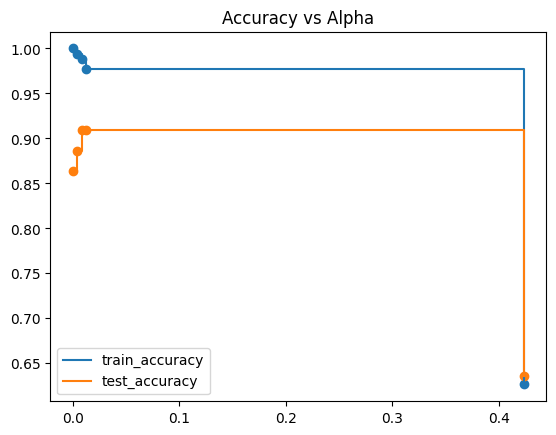

In [170]:
plot_ccp(clfs)

Observations:
- According to the picture above, the third value of alpha results in a test accuracy of higher than 90%. Moreover, the train overfits is likely to decrease.

####################
Accuracy on train:  0.9885057471264368
Accuracy on test:  0.9090909090909091
####################
Recall on train:  1.0
Recall on test:  0.9642857142857143
####################
Precision on train:  0.9819819819819819
Precision on test:  0.9


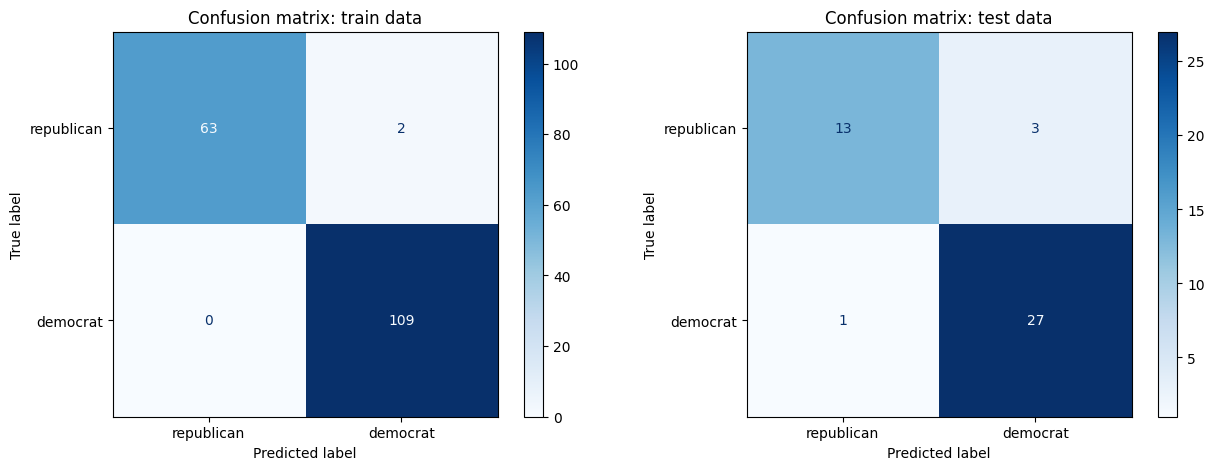

In [171]:
tree_pruned = tree.DecisionTreeClassifier(random_state = 1,ccp_alpha = ccp_alphas[2])

tree_pruned.fit(X_train_imputed,y_train)
evaluate(tree_pruned)

Observations:
- The pruned tree with a cost complexity parameter of `0.00862`,however, did not improve model performance anymore.

#### Random Forest
##### Random Forest 1

####################
Accuracy on train:  1.0
Accuracy on test:  0.8863636363636364
####################
Recall on train:  1.0
Recall on test:  0.9642857142857143
####################
Precision on train:  1.0
Precision on test:  0.8709677419354839


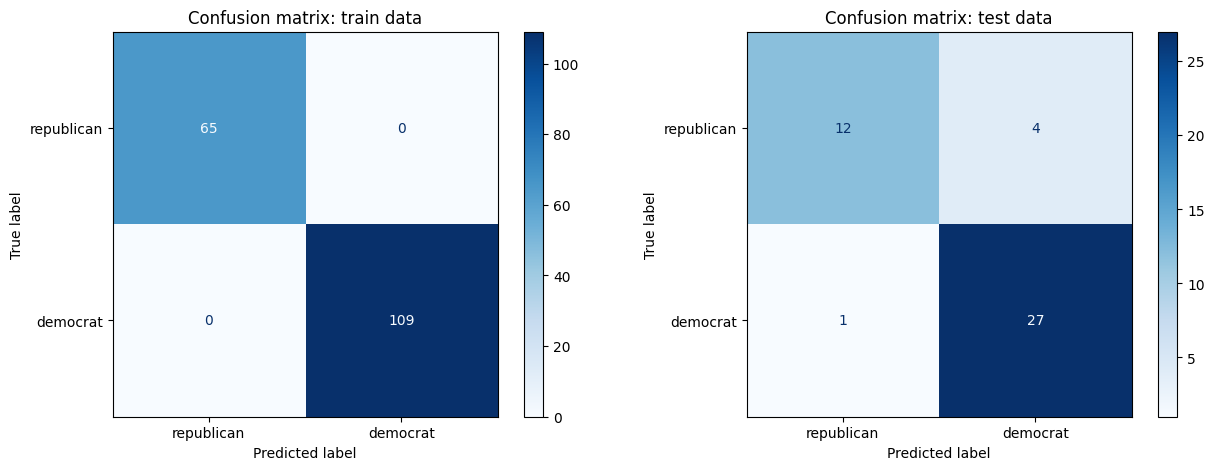

In [172]:
rf_1 = RandomForestClassifier(random_state = 1,)
evaluate(rf_1)

Observations:
- The first model of random forest does not bring much improvement when compared to the decision trees

##### Balanced Random Forest 2

In [173]:
rf_2 = RandomForestClassifier(random_state = 1,class_weight = 'balanced')

####################
Accuracy on train:  1.0
Accuracy on test:  0.8863636363636364
####################
Recall on train:  1.0
Recall on test:  0.9642857142857143
####################
Precision on train:  1.0
Precision on test:  0.8709677419354839


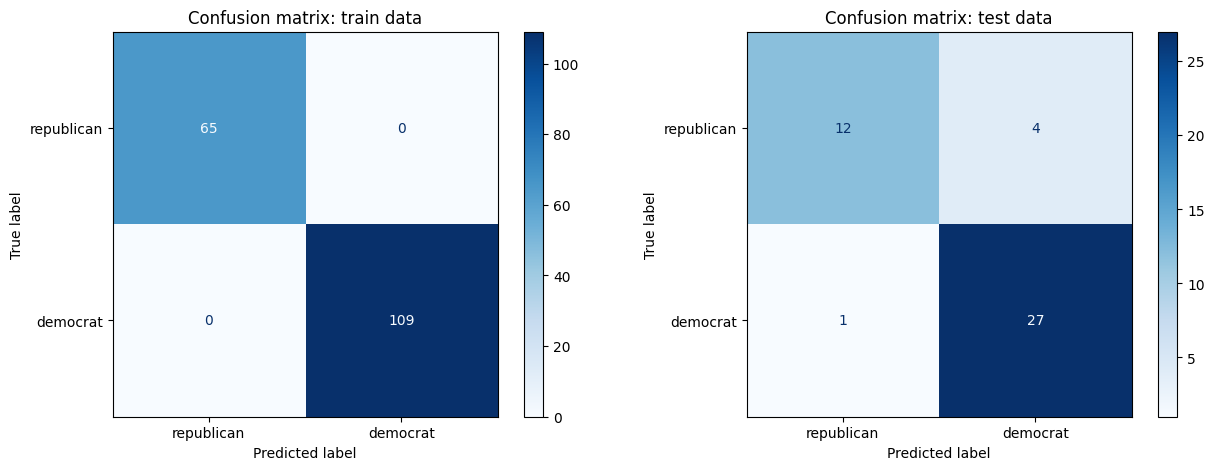

In [174]:
evaluate(rf_2)

##### Hyperparameter Tuning

In [180]:
imputer =  KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean')

pipeline = Pipeline([
    ('imputer', imputer),
    ('rf',RandomForestClassifier(random_state = 1))
])
#parameter grid
param_grid = {
    'rf__bootstrap': [True,False],
    'rf__n_estimators': [10,30,50,80,100, 200, 300,400,500,600, 1000],
    'rf__max_depth':[3,5,8,15,20,25,30] ,
    'rf__class_weight':[None,'balanced'],
    'imputer__n_neighbors':[5],
    'imputer__weights':['distance'],
    'imputer__metric': ['nan_euclidean']}


kf = KFold(n_splits= 10, shuffle=True, random_state=1)
scorer = make_scorer(accuracy_score)


grid_search_rf = GridSearchCV(estimator = pipeline, param_grid = param_grid, 
                          cv = kf, n_jobs = -1, verbose = 2,scoring = scorer)

In [182]:
start_time = time.time()
grid_search_rf.fit(X_train, y_train)
end_time = time.time()

Fitting 10 folds for each of 308 candidates, totalling 3080 fits
[CV] END imputer__metric=nan_euclidean, imputer__n_neighbors=5, imputer__weights=distance, rf__bootstrap=True, rf__class_weight=None, rf__max_depth=3, rf__n_estimators=10; total time=   0.3s
[CV] END imputer__metric=nan_euclidean, imputer__n_neighbors=5, imputer__weights=distance, rf__bootstrap=True, rf__class_weight=None, rf__max_depth=3, rf__n_estimators=10; total time=   0.2s
[CV] END imputer__metric=nan_euclidean, imputer__n_neighbors=5, imputer__weights=distance, rf__bootstrap=True, rf__class_weight=None, rf__max_depth=3, rf__n_estimators=10; total time=   0.2s
[CV] END imputer__metric=nan_euclidean, imputer__n_neighbors=5, imputer__weights=distance, rf__bootstrap=True, rf__class_weight=None, rf__max_depth=3, rf__n_estimators=10; total time=   0.2s
[CV] END imputer__metric=nan_euclidean, imputer__n_neighbors=5, imputer__weights=distance, rf__bootstrap=True, rf__class_weight=None, rf__max_depth=3, rf__n_estimators=10;

In [183]:
print('Average execution time across 10 folds ',str((end_time-start_time)/10))

Average execution time across 10 folds  110.45579750537873


In [184]:
#  best estimator - 

# RandomForestClassifier(max_depth=3, n_estimators=30, random_state=1)
rf_best = grid_search_rf.best_estimator_
rf_best

Pipeline(steps=[('imputer', KNNImputer(weights='distance')),
                ('rf',
                 RandomForestClassifier(max_depth=3, n_estimators=30,
                                        random_state=1))])

####################
Accuracy on train:  0.9827586206896551
Accuracy on test:  0.9318181818181818
####################
Recall on train:  0.981651376146789
Recall on test:  0.9285714285714286
####################
Precision on train:  0.9907407407407407
Precision on test:  0.9629629629629629


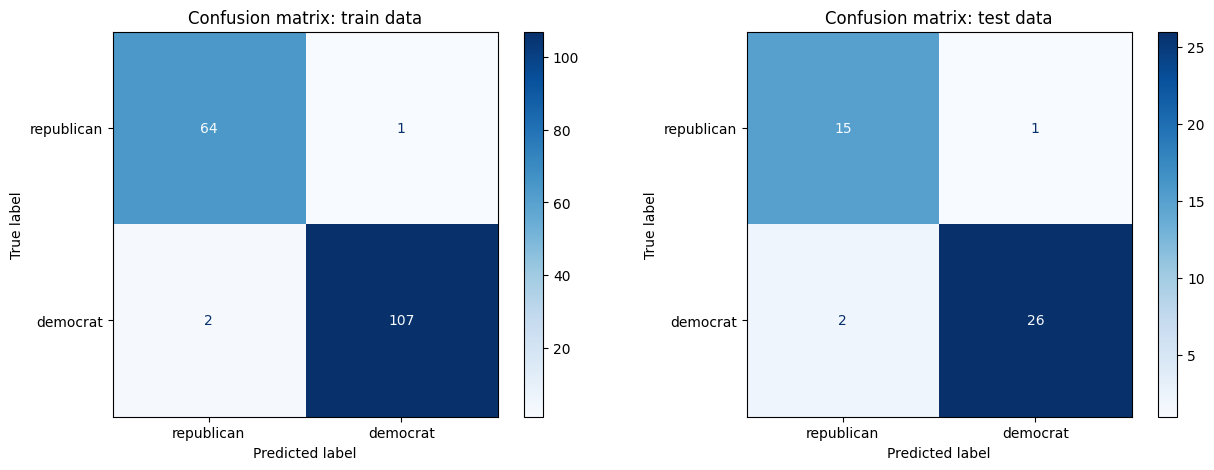

In [185]:
evaluate(rf_best,X_train,X_test)

Observations:

- This model delivers the best test accuracy so far.

##### Parameter Tuning with Randomized Search

In [189]:
imputer =  KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean')

pipeline = Pipeline([
    ('imputer', imputer),
    ('rf',RandomForestClassifier(random_state = 1))
])
#parameter grid
param_dist = {
    'rf__bootstrap': [True,False],
    'rf__n_estimators': [10,30,50,80,100, 200, 300,400,500,600, 1000],
    'rf__max_depth':[3,5,8,15,20,25,30] ,
    'rf__class_weight':[None,'balanced'],
    'imputer__n_neighbors':[5],
    'imputer__weights':['distance'],
    'imputer__metric': ['nan_euclidean']}


kf = KFold(n_splits= 10, shuffle=True, random_state=1)
scorer = make_scorer(accuracy_score)

rand_search_rf = RandomizedSearchCV(estimator = pipeline, param_distributions = param_dist, 
                          cv = kf, n_jobs = -1, verbose = 2,scoring = scorer,random_state = 1)

In [190]:
start_time = time.time()
rand_search_rf.fit(X_train,y_train)
end_time = time.time()
print('Average execution time across 10 fold: ',str((end_time-start_time)/10))

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END imputer__metric=nan_euclidean, imputer__n_neighbors=5, imputer__weights=distance, rf__bootstrap=True, rf__class_weight=None, rf__max_depth=30, rf__n_estimators=400; total time=   4.9s
[CV] END imputer__metric=nan_euclidean, imputer__n_neighbors=5, imputer__weights=distance, rf__bootstrap=True, rf__class_weight=None, rf__max_depth=30, rf__n_estimators=400; total time=   5.0s
[CV] END imputer__metric=nan_euclidean, imputer__n_neighbors=5, imputer__weights=distance, rf__bootstrap=True, rf__class_weight=None, rf__max_depth=30, rf__n_estimators=400; total time=   4.9s
[CV] END imputer__metric=nan_euclidean, imputer__n_neighbors=5, imputer__weights=distance, rf__bootstrap=True, rf__class_weight=None, rf__max_depth=30, rf__n_estimators=400; total time=   5.1s
[CV] END imputer__metric=nan_euclidean, imputer__n_neighbors=5, imputer__weights=distance, rf__bootstrap=True, rf__class_weight=None, rf__max_depth=30, rf__n_estimat

In [192]:
# RandomForestClassifier(max_depth=30, n_estimators=400, random_state=1)
best_rf_rand = rand_search_rf.best_estimator_
best_rf_rand

Pipeline(steps=[('imputer', KNNImputer(weights='distance')),
                ('rf',
                 RandomForestClassifier(max_depth=30, n_estimators=400,
                                        random_state=1))])

####################
Accuracy on train:  1.0
Accuracy on test:  0.9090909090909091
####################
Recall on train:  1.0
Recall on test:  0.9642857142857143
####################
Precision on train:  1.0
Precision on test:  0.9


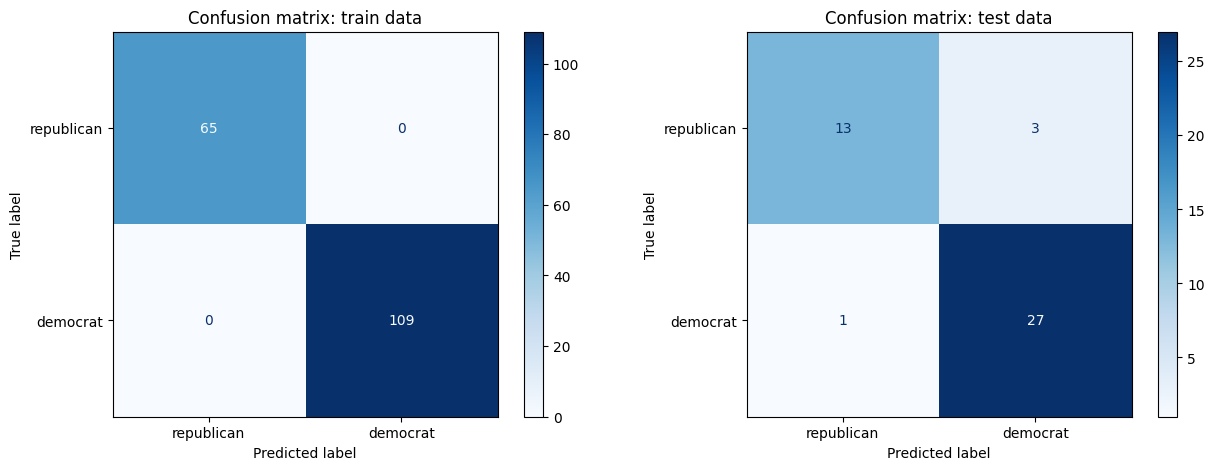

In [193]:
evaluate(best_rf_rand)

Observations:
- Best model based on randomized search does not offer optimal results as the overfit is quite high.

### k-NN Classifier

In [388]:
X_train = X_train_imputed
X_train.head()


,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
2,1.0,0.6,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0


In [389]:
y_train.head()

117    1
212    1
114    1
42     0
113    1
Name: class, dtype: int64

In [390]:
X_test = X_test_imputed
X_test.head()

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.000000,0.000000,0.000000,1.0
1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.174479,0.213692,0.710659,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.000000,1.000000,0.000000,1.0
3,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,1.0
4,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.000000,1.000000,0.000000,1.0


In [391]:
num_class_1 = sum(y_train==1)
num_class_0 = sum(y_train==0)
print(num_class_1, num_class_0)

109 65


Since k-NN classifier relies on distance, scaling (Z-score standardisation) is a must!
let's ensure that all variables have mean of 0 and standard deviation of 1.
Problem: categorical attributes (no distance in mathematical sense)

In [392]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.fit_transform(X_test)

print('TRAINING')
print('Original data:')
print('Mean:')
print(X_train.mean(axis=0))
print('Std:')
print(X_train.std(axis=0))
print()
print('Standardized data:')
print('Mean:')
print(X_train_standardized.mean(axis=0))
print('Std:')
print(X_train_standardized.std(axis=0))

print('#'*100)


print('TESTING')
print('Original data:')
print('Mean:')
print(X_test.mean(axis=0))
print('Std:')
print(X_test.std(axis=0))
print()
print('Standardized data:')
print('Mean:')
print(X_test_standardized.mean(axis=0))
print('Std:')
print(X_test_standardized.std(axis=0))

X_train = X_train_standardized
X_test = X_test_standardized

TRAINING
Original data:
Mean:
handicapped-infants                       0.491237
water-project-cost-sharing                0.476129
adoption-of-the-budget-resolution         0.596359
physician-fee-freeze                      0.374407
el-salvador-aid                           0.487920
religious-groups-in-schools               0.601183
anti-satellite-test-ban                   0.574520
aid-to-nicaraguan-contras                 0.588800
mx-missile                                0.486593
immigration                               0.495977
synfuels-crporation-cutback               0.368036
education-spending                        0.396410
superfund-right-to-sue                    0.507369
crime                                     0.541071
duty-free-exports                         0.485855
export-administration-act-south-africa    0.812760
dtype: float64
Std:
handicapped-infants                       0.496197
water-project-cost-sharing                0.482082
adoption-of-the-budget-resolutio

In [398]:
def knn_evaluate(model):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # accuracy
    print("#"*40)
    print("Accuracy on train: ", accuracy_score(y_true=y_train, y_pred=y_train_pred))
    print("Accuracy on test: ", accuracy_score(y_true=y_test, y_pred=y_test_pred))
    # recall
    print("#"*40)
    print("Recall on train: ", recall_score(y_true=y_train, y_pred=y_train_pred, average='macro'))
    print("Recall on test: ", recall_score(y_true=y_test, y_pred=y_test_pred, average = 'macro'))
    # precision
    print("#"*40)
    print("Precision on train: ", precision_score(y_true=y_train, y_pred=y_train_pred, average='macro'))
    print("Precision on test: ", precision_score(y_true=y_test, y_pred=y_test_pred, average='macro'))

    # plot confusion matrices
    print("#"*40)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    c_1 = confusion_matrix(y_true=y_train, y_pred=y_train_pred)
    cmd_1 = ConfusionMatrixDisplay(c_1, display_labels=['republican', 'democrat'])
    cmd_1.plot(ax=ax[0], cmap=plt.cm.Blues)
    ax[0].set_title("Confusion matrix: train data")

    c_2 = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
    cmd_2 = ConfusionMatrixDisplay(c_2, display_labels=['republican', 'democrat'])
    cmd_2.plot(ax=ax[1], cmap=plt.cm.Blues)
    ax[1].set_title("Confusion matrix: test data")

    k = model.n_neighbors
    plt.tight_layout()
    plt.suptitle("k-NN classifier, k = " + str(k), fontsize=15, ha='center')
    plt.subplots_adjust(top=0.85)

    plt.show()


########################################
Accuracy on train:  1.0
Accuracy on test:  0.8636363636363636
########################################
Recall on train:  1.0
Recall on test:  0.8526785714285714
########################################
Precision on train:  1.0
Precision on test:  0.8526785714285714
########################################


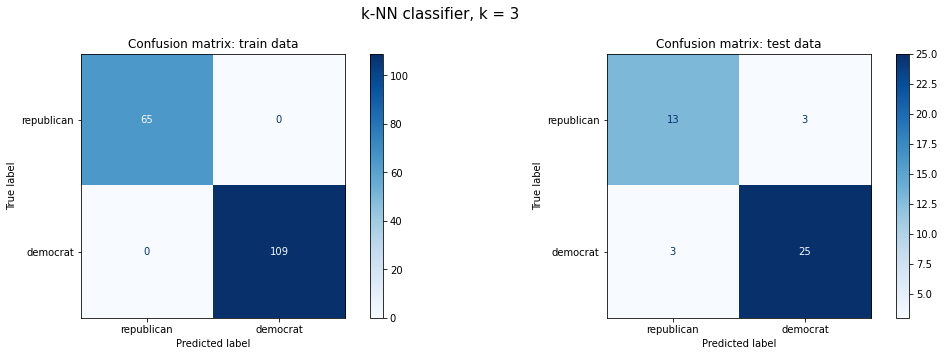

In [399]:
# 1st model
from sklearn.neighbors import KNeighborsClassifier
k = 3
knn_1 = KNeighborsClassifier(n_neighbors=k, weights='distance')
knn_1.fit(X_train, y_train)

knn_evaluate(knn_1)

########################################
Accuracy on train:  1.0
Accuracy on test:  0.8863636363636364
########################################
Recall on train:  1.0
Recall on test:  0.8839285714285714
########################################
Precision on train:  1.0
Precision on test:  0.8747276688453158
########################################


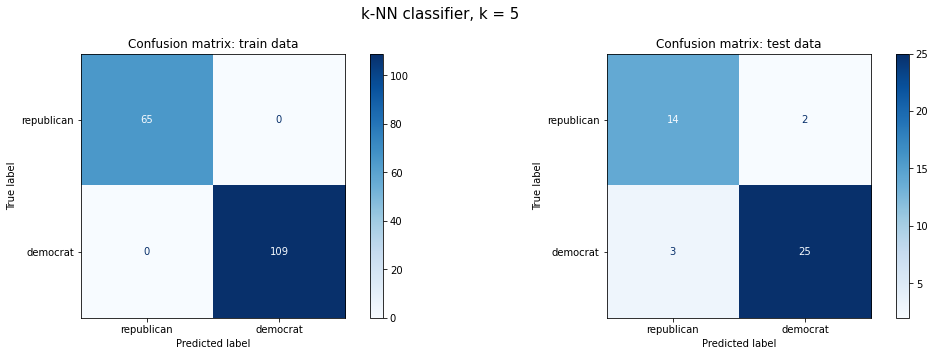

In [400]:
# 2nd model
from sklearn.neighbors import KNeighborsClassifier
k = 5
knn_2 = KNeighborsClassifier(n_neighbors=k, weights='distance')
knn_2.fit(X_train, y_train)

knn_evaluate(knn_2)

### 1. Holdout method
Since the performance of classifier depends greatly on training + testing split, in order to obtain a more objective measure of performance, the holdout method can be used.


In [415]:
def hold_out(k):
    N = 100
    accuracy_test = np.zeros(N)
    accuracy_train = np.zeros(N)
    for i in range(0, N):
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=i, stratify=Y['class'])
        
        # start_imputation
        # For every split imputation is done...
        
        # dropping this column since it does not bring any value
        X_train.drop('ID', axis=1, inplace=True)
        y_train['class'] = y_train['class'].map({'democrat': 1, 'republican': 0})
        y_train['class'] = y_train['class'].astype('int64')
        y_train_id = y_train['ID']
        y_train = y_train['class']

        imputer = KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean')
        X_train.replace('unknown', float('nan'), inplace=True)
        X_train = X_train.replace({'y':1, 'n':0})
        X_train_imputed = imputer.fit_transform(X_train)
        X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns)

        X_test.drop('ID', axis=1, inplace=True)
        y_test['class'] = y_test['class'].map({'democrat': 1, 'republican': 0})
        y_test['class'] = y_test['class'].astype('int64')
        y_test_id = y_test['ID']
        y_test = y_test['class']

        imputer = KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean')
        X_test.replace('unknown', float('nan'), inplace=True)
        X_test = X_test.replace({'y':1, 'n':0})
        X_test_imputed = imputer.fit_transform(X_test)
        X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns)
        
        # end_imputation
                                      
        X_train = X_train_imputed
        X_test = X_test_imputed


        # Z-score normalization
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_train_pred = knn.predict(X_train)
        y_test_pred = knn.predict(X_test)
        # accuracy
        accuracy_train[i] = accuracy_score(y_true=y_train, y_pred=y_train_pred)
        accuracy_test[i] = accuracy_score(y_true=y_test, y_pred=y_test_pred)
        
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(1, N+1, 1), accuracy_train, 'o-', color='darkblue', label='training set')
    plt.plot(np.arange(1, N+1, 1), accuracy_test, 'o-', color='royalblue', label='testing set')
    plt.legend()
    plt.title('Accuracy, holdout method, k-NN clasifier k = '+str(k))
    plt.ylabel('accuracy')

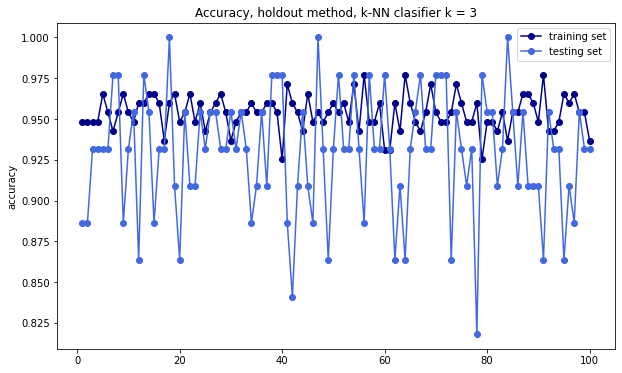

In [416]:
hold_out(k=3)

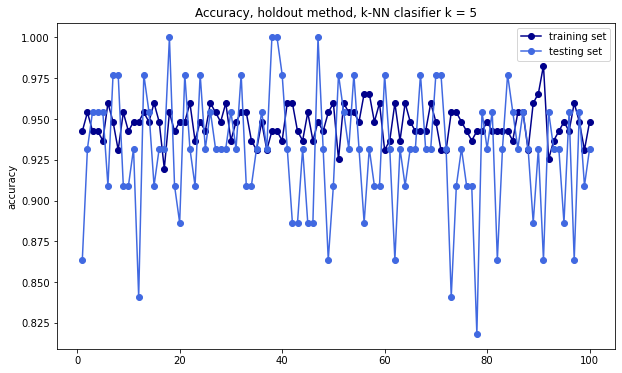

In [417]:
hold_out(k=5)

In [431]:
### 2. k-fold cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline


def hold_out_and_cross_val(k):
    N = 100
    accuracy_test_hold_out = np.zeros(N)
    accuracy_train_hold_out = np.zeros(N)
    accuracy_test_cross_val = np.zeros(N)
    

    for i in range(0, N):
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=i, stratify=Y)
        
        imputer = KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean')
        X_train_imputed = imputer.fit_transform(X_train)
        X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns)
        
        X_test_imputed = imputer.fit_transform(X_test)
        X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns)
        
        X_train = X_train_imputed
        X_test = X_test_imputed
        
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)
        
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_train_pred = knn.predict(X_train)
        y_test_pred = knn.predict(X_test)
        # accuracy
        accuracy_test_hold_out[i] = accuracy_score(y_true=y_test, y_pred=y_test_pred)
        
        # perform k-fold cross-validation
        imputer = KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean')

        estimators = [('impute', imputer), ('standardize', StandardScaler()), ('knn', KNeighborsClassifier())]
        pipeline = Pipeline(estimators)

        scores = cross_val_score(pipeline, X, Y, cv=10)
        accuracy_test_cross_val[i] = np.mean(scores)
        
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(1, N+1, 1), accuracy_test_cross_val, 'o-', color='darkblue', label='k-fold cross-validation')
    plt.plot(np.arange(1, N+1, 1), accuracy_test_hold_out, 'o-', color='royalblue', label='hold out')
    plt.legend()
    plt.title('Accuracy on testing set, holdout and k-fold cross-validation method, k-NN clasifier k = '+str(k))
    plt.ylabel('accuracy')

In [434]:
X.drop('ID', axis=1, inplace=True)
X.replace('unknown', float('nan'), inplace=True)
X = X.replace({'y':1, 'n':0})
Y['class'] = Y['class'].map({'democrat': 1, 'republican': 0})
Y['class'] = Y['class'].astype('int64')
Y = Y['class']

C:\Users\sofij\AppData\Local\Temp/ipykernel_10392/3915945584.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['class'] = Y['class'].map({'democrat': 1, 'republican': 0})
C:\Users\sofij\AppData\Local\Temp/ipykernel_10392/3915945584.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['class'] = Y['class'].astype('int64')


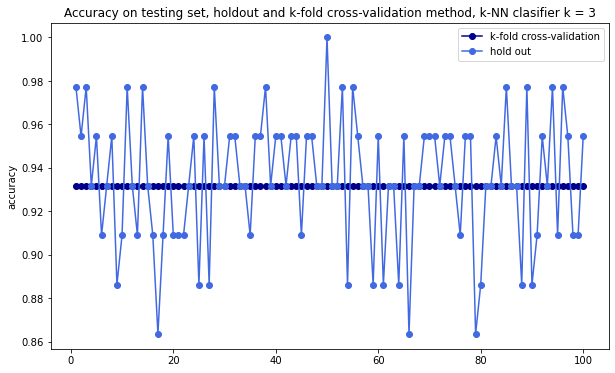

In [437]:
hold_out_and_cross_val(k=3)

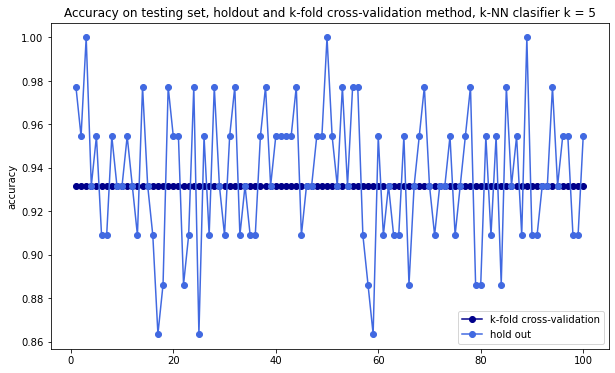

In [438]:
hold_out_and_cross_val(k=5)

### Trade-off: complexity vs. generalization
Plotting the (validation) testing curve in order to find optimal k

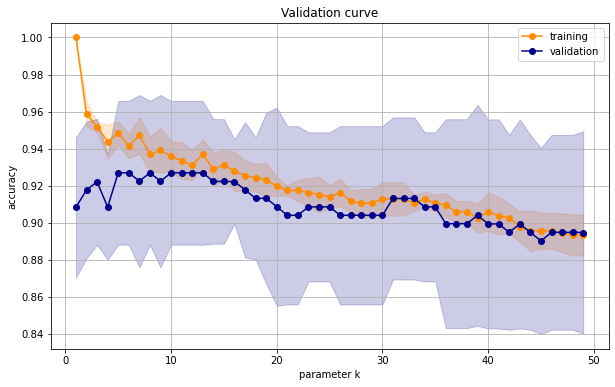

In [441]:
from sklearn.model_selection import validation_curve
# evaluate model performance using validation_curve
param_range = np.arange(1, 50)

imputer = KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean')
estimators = [('impute', imputer), ('standardize', StandardScaler()), ('knn', KNeighborsClassifier())]
pipeline = Pipeline(estimators)
train_scores, test_scores = validation_curve(
    pipeline,
    X, Y,
    param_name='knn__n_neighbors',
    param_range=param_range,
    cv=5,
    scoring='accuracy'
)

# column: score for specific fold for different k
# row: results for specific k for different folds

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, 'o-', label='training', color='darkorange')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color='darkorange')
plt.plot(param_range, test_mean, 'o-', label='validation', color='darkblue')
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.2, color='darkblue')

plt.title('Validation curve')
plt.xlabel('parameter k')
plt.ylabel('accuracy')
plt.legend()
plt.grid()
plt.show()

In [468]:
X = congress.drop(['class'], axis=1)
Y = congress[['class', 'ID']] # have to take ID into account because of the output format
X.drop('ID', axis=1, inplace=True)
X.replace('unknown', float('nan'), inplace=True)
X = X.replace({'y':1, 'n':0})


#Splitting data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state = 1234,stratify=Y['class'])


imputer = KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean')
X_train_imputed = imputer.fit_transform(X_train)
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns)

X_train= scaler.fit_transform(X_train_imputed)

y_train['class'] = y_train['class'].map({'democrat': 1, 'republican': 0})
y_train['class'] = y_train['class'].astype('int64')
y_train_id = y_train['ID']
y_train = y_train['class']



X_test_imputed = imputer.fit_transform(X_test)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns)

X_test = scaler.fit_transform(X_test_imputed)

y_test['class'] = y_test['class'].map({'democrat': 1, 'republican': 0})
y_test['class'] = y_test['class'].astype('int64')
y_test_id = y_test['ID']
y_test = y_test['class']



########################################
Accuracy on train:  0.9770114942528736
Accuracy on test:  0.8863636363636364
########################################
Recall on train:  0.9754410726887791
Recall on test:  0.8839285714285714
########################################
Precision on train:  0.9754410726887791
Precision on test:  0.8747276688453158
########################################


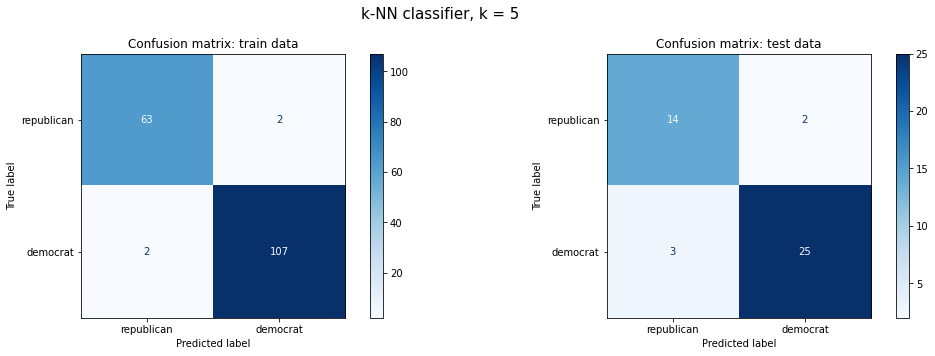

In [470]:
# Let's choose k=5 as optimal
# Training such classifier and evaluating 
k = 5
knn_optimal = KNeighborsClassifier(n_neighbors=k)
knn_optimal.fit(X_train, y_train)

knn_evaluate(knn_optimal)

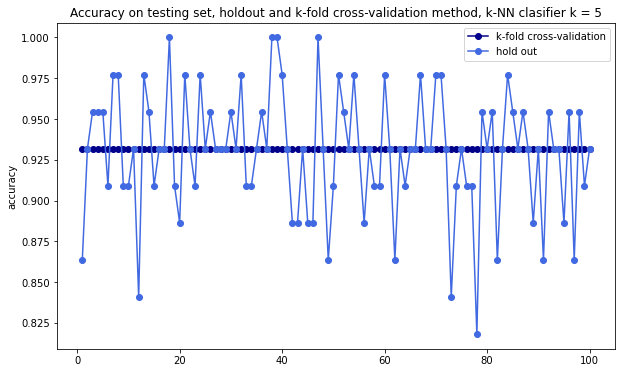

In [474]:
Y = Y['class']
hold_out_and_cross_val(k=5)  # number of folds: 10

### Efficiency: Runtime
Total runtime for training & testing k-NN classifier (k-fold cross validation), 
- k  : 5
- cv : 10

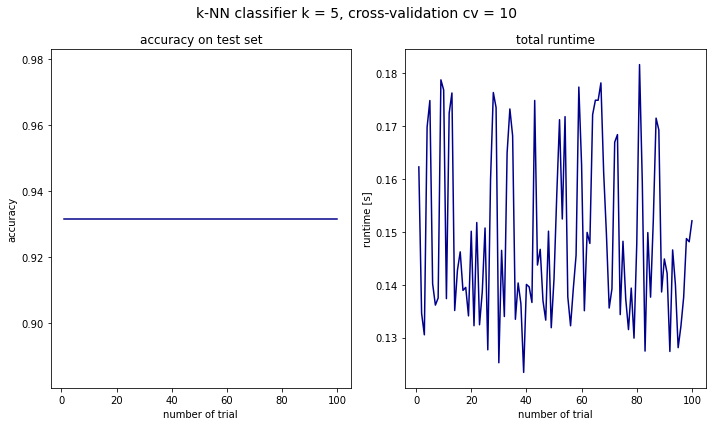

In [477]:
import time

runtime = np.zeros(100)
acc_test = np.zeros(100)

for i in range(0, 100):
    start_time = time.time()
    
    imputer = KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean')
    estimators = [('impute', imputer), ('standardize', StandardScaler()), ('knn', KNeighborsClassifier())]
    pipeline = Pipeline(estimators)
    scores = cross_val_score(pipeline, X, Y, cv=10)
    acc_test[i] = np.mean(scores)

    end_time = time.time()

    runtime[i] = end_time - start_time
    
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, 101), acc_test, '-', color='darkblue')
plt.ylabel('accuracy')
plt.xlabel('number of trial')
plt.title('accuracy on test set')

plt.subplot(1, 2, 2)
plt.plot(np.arange(1, 101), runtime, '-', color='darkblue')
plt.ylabel('runtime [s]')
plt.xlabel('number of trial')
plt.title('total runtime')

plt.suptitle('k-NN classifier k = 5, cross-validation cv = 10', fontsize=14)
plt.tight_layout()

plt.show()

In [478]:
print('Mean accuracy : ', str(np.mean(acc_test)))
print('Mean runtime  : ', str(np.mean(runtime)), ' s')

Mean accuracy :  0.9316017316017314
Mean runtime  :  0.14884399652481078  s
